The objective of this notebook is to apply the methods for clustering found with the original dataset to the duplicates one. The methods of clustering are not the same.

In [86]:
# Jupyter notebook: optional formatting extension
# %load_ext nb_black

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import os
import datetime
import math
from math import ceil

# Preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder

# Clustering
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, estimate_bandwidth
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor

# Clustering evaluation
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score

# Hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Stats
from scipy.stats import chi2_contingency, stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.mosaicplot import mosaic

# Dimensionality reduction
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Model selection
from sklearn.model_selection import GridSearchCV

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import plotly.express as px
import matplotlib.cm as cm


In [87]:
FlightsDB_1 = pd.read_csv('FlightsDB_1.csv')
FlightsDB_2 = pd.read_csv('FlightsDB_2.csv')

In [88]:
# show flightsDB_1 ordering by Loyalty#
FlightsDB_1.sort_values(by=['Loyalty#'])


,Unnamed: 0,Loyalty#,PointsRedeemedRatio,FlightsWithCompanionsRatio,AvgDistancePerFlight,KMPerRedeemedPoint,UnredeemedPoints,HasBonus,AvgMonthlyFlights,sr_jan,...,Income,Marital Status,LoyaltyStatus,EnrollmentDateOpening,CancellationDate,Customer Lifetime Value,EnrollmentType,Cancelled,Time on Program,Loyalty#_new
0,0,101902,0.182369,0.176966,2131.451124,54.850123,62023,0,5.741935,0.016854,...,0.0,Married,Aurora,2020-01-07,0,6265.34,Standard,N,723 days,101902_1
1,1,106001,0.395167,0.241814,2039.651889,25.313924,48960,0,5.591549,0.093199,...,14973.0,Divorced,Star,2015-07-16,0,12168.74,Standard,N,2359 days,106001_1
2,2,114414,0.034855,0.205776,2782.755957,286.978183,74377,0,3.957143,0.090253,...,0.0,Married,Nova,2015-11-06,0,3591.07,Standard,N,2246 days,114414_1
3,3,130331,0.202501,0.426230,2851.959016,49.395088,27741,0,2.595745,0.000000,...,64640.0,Divorced,Nova,2019-12-01,0,2862.73,Standard,N,760 days,130331_1
4,4,135421,0.141525,0.328947,2590.785197,70.674686,67598,0,4.676923,0.055921,...,0.0,Divorced,Star,2017-12-16,0,5304.54,Standard,N,1475 days,135421_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,120,981508,0.174918,0.357143,2145.008929,57.186622,19816,0,2.488889,0.000000,...,44784.0,Married,Aurora,2018-04-01,0,5786.49,Standard,N,1369 days,981508_1
121,121,988392,0.407019,0.165116,2445.227907,24.575155,62333,0,6.056338,0.065116,...,0.0,Single,Aurora,2015-05-15,0,9022.08,Standard,N,2421 days,988392_1
122,122,989528,0.000000,0.223529,2096.891176,0.000000,35639,0,3.469388,0.035294,...,83772.0,Divorced,Star,2015-04-01,0,2453.41,Standard,N,2465 days,989528_1
123,123,990512,0.000000,0.351351,3142.621622,0.000000,11625,0,0.925000,0.000000,...,0.0,Single,Star,2018-10-21,0,1904.00,Standard,N,1166 days,990512_1


In [89]:
FlightsDB_1=FlightsDB_1.drop(columns=['Gender', 'Loyalty#_new', 'Longitude', 'Latitude', 'First Name', 'Last Name', 'Unnamed: 0', 'Customer Name', 'Country', 'City', 'Gender'])
FlightsDB_2=FlightsDB_2.drop(columns=['Gender', 'Loyalty#_new', 'Longitude', 'Latitude', 'First Name', 'Last Name', 'Unnamed: 0', 'Customer Name', 'Country', 'City', 'Gender'])

In [90]:
FlightsDB_1.columns

Index(['Loyalty#', 'PointsRedeemedRatio', 'FlightsWithCompanionsRatio',
       'AvgDistancePerFlight', 'KMPerRedeemedPoint', 'UnredeemedPoints',
       'HasBonus', 'AvgMonthlyFlights', 'sr_jan', 'sr_feb', 'sr_mar', 'sr_apr',
       'sr_may', 'sr_jun', 'sr_jul', 'sr_aug', 'sr_sep', 'sr_oct', 'sr_nov',
       'sr_dec', 'Province or State', 'Postal code', 'Education',
       'Location Code', 'Income', 'Marital Status', 'LoyaltyStatus',
       'EnrollmentDateOpening', 'CancellationDate', 'Customer Lifetime Value',
       'EnrollmentType', 'Cancelled', 'Time on Program'],
      dtype='object')

In [91]:
FlightsDB_1=FlightsDB_1.drop(columns='Postal code')
FlightsDB_2=FlightsDB_2.drop(columns='Postal code')


In [92]:
FlightsDB_1.columns

Index(['Loyalty#', 'PointsRedeemedRatio', 'FlightsWithCompanionsRatio',
       'AvgDistancePerFlight', 'KMPerRedeemedPoint', 'UnredeemedPoints',
       'HasBonus', 'AvgMonthlyFlights', 'sr_jan', 'sr_feb', 'sr_mar', 'sr_apr',
       'sr_may', 'sr_jun', 'sr_jul', 'sr_aug', 'sr_sep', 'sr_oct', 'sr_nov',
       'sr_dec', 'Province or State', 'Education', 'Location Code', 'Income',
       'Marital Status', 'LoyaltyStatus', 'EnrollmentDateOpening',
       'CancellationDate', 'Customer Lifetime Value', 'EnrollmentType',
       'Cancelled', 'Time on Program'],
      dtype='object')

In [93]:
FlightsDB_1=FlightsDB_1.drop(columns='Location Code')
FlightsDB_2=FlightsDB_2.drop(columns='Location Code')

In [94]:

# Convert EnrollmentDateOpening to datetime if not already
FlightsDB_1['EnrollmentDateOpening'] = pd.to_datetime(FlightsDB_1['EnrollmentDateOpening'])
FlightsDB_2['EnrollmentDateOpening'] = pd.to_datetime(FlightsDB_2['EnrollmentDateOpening'])

# Extract month and create EnrollmentMonth
FlightsDB_1['EnrollmentMonth'] = FlightsDB_1['EnrollmentDateOpening'].dt.month
FlightsDB_2['EnrollmentMonth'] = FlightsDB_2['EnrollmentDateOpening'].dt.month


In [95]:
# Remove the " days" text and convert to integer
FlightsDB_1['Time on Program'] = FlightsDB_1['Time on Program'].str.replace(' days', '').astype(int)
FlightsDB_2['Time on Program'] = FlightsDB_2['Time on Program'].str.replace(' days', '').astype(int)

# Create Reenroll column: 1 if Time on Program < 0 else 0
FlightsDB_1['Reenroll'] = FlightsDB_1['Time on Program'].apply(lambda x: 1 if x < 0 else 0)
FlightsDB_2['Reenroll'] = FlightsDB_2['Time on Program'].apply(lambda x: 1 if x < 0 else 0)

print(FlightsDB_1)
print(FlightsDB_2)

FlightsDB_1[FlightsDB_1['Time on Program']<0]
FlightsDB_2[FlightsDB_2['Time on Program']<0]


     Loyalty#  PointsRedeemedRatio  FlightsWithCompanionsRatio  \
0      101902             0.182369                    0.176966   
1      106001             0.395167                    0.241814   
2      114414             0.034855                    0.205776   
3      130331             0.202501                    0.426230   
4      135421             0.141525                    0.328947   
..        ...                  ...                         ...   
120    981508             0.174918                    0.357143   
121    988392             0.407019                    0.165116   
122    989528             0.000000                    0.223529   
123    990512             0.000000                    0.351351   
124    992168             0.266319                    0.231198   

     AvgDistancePerFlight  KMPerRedeemedPoint  UnredeemedPoints  HasBonus  \
0             2131.451124           54.850123             62023         0   
1             2039.651889           25.313924        

,Loyalty#,PointsRedeemedRatio,FlightsWithCompanionsRatio,AvgDistancePerFlight,KMPerRedeemedPoint,UnredeemedPoints,HasBonus,AvgMonthlyFlights,sr_jan,sr_feb,...,Marital Status,LoyaltyStatus,EnrollmentDateOpening,CancellationDate,Customer Lifetime Value,EnrollmentType,Cancelled,Time on Program,EnrollmentMonth,Reenroll
51,546259,0.0,0.000000,0.000000,0.0,0,0,0.000000,0.0,0.0,...,Married,Nova,2020-03-01,2019-05-21 00:00:00,7218.02,Standard,Y,-285,3,1
92,841296,0.0,1.000000,3216.872727,0.0,3538,0,0.289474,1.0,0.0,...,Married,Nova,2020-05-01,2020-01-12 00:00:00,5226.29,Standard,Y,-110,5,1
109,950304,0.0,0.346939,1563.020408,0.0,7656,0,1.256410,0.0,0.0,...,Married,Nova,2021-07-28,2019-03-28 00:00:00,7521.19,Standard,Y,-853,7,1


In [96]:
# For Reenroll = 1, set CancellationDate to NaN
FlightsDB_2.loc[FlightsDB_2['Reenroll'] == 1, 'CancellationDate'] = pd.NaT
max_enrollment_date = FlightsDB_2['EnrollmentDateOpening'].max()

# Calculate Time on Program in days
FlightsDB_2['Time on Program'] = (max_enrollment_date - FlightsDB_2['EnrollmentDateOpening']).dt.days

# Optional: check if there are still negative values
print(FlightsDB_2[FlightsDB_2['Time on Program'] < 0])

# View updated dataframe
FlightsDB_2.head()

Empty DataFrame
Columns: [Loyalty#, PointsRedeemedRatio, FlightsWithCompanionsRatio, AvgDistancePerFlight, KMPerRedeemedPoint, UnredeemedPoints, HasBonus, AvgMonthlyFlights, sr_jan, sr_feb, sr_mar, sr_apr, sr_may, sr_jun, sr_jul, sr_aug, sr_sep, sr_oct, sr_nov, sr_dec, Province or State, Education, Income, Marital Status, LoyaltyStatus, EnrollmentDateOpening, CancellationDate, Customer Lifetime Value, EnrollmentType, Cancelled, Time on Program, EnrollmentMonth, Reenroll]
Index: []

[0 rows x 33 columns]


,Loyalty#,PointsRedeemedRatio,FlightsWithCompanionsRatio,AvgDistancePerFlight,KMPerRedeemedPoint,UnredeemedPoints,HasBonus,AvgMonthlyFlights,sr_jan,sr_feb,...,Marital Status,LoyaltyStatus,EnrollmentDateOpening,CancellationDate,Customer Lifetime Value,EnrollmentType,Cancelled,Time on Program,EnrollmentMonth,Reenroll
0,101902,0.182369,0.176966,2131.451124,54.850123,62023,0,5.741935,0.016854,0.022472,...,Married,Aurora,2020-03-19,0,8609.16,Standard,N,624,3,0
1,106001,0.395167,0.241814,2039.651889,25.313924,48960,0,5.591549,0.093199,0.110831,...,Single,Star,2016-01-11,0,4914.04,Standard,N,2153,1,0
2,114414,0.034855,0.205776,2782.755957,286.978183,74377,0,3.957143,0.090253,0.126354,...,Single,Star,2015-12-18,0,2617.70,Standard,N,2177,12,0
3,130331,0.202501,0.426230,2851.959016,49.395088,27741,0,2.595745,0.000000,0.032787,...,Married,Nova,2021-01-28,0,11638.90,Standard,N,309,1,0
4,135421,0.141525,0.328947,2590.785197,70.674686,67598,0,4.676923,0.055921,0.069079,...,Married,Aurora,2020-01-07,0,17441.64,Standard,N,696,1,0


## Loyalty Perspective

In [97]:
features = ['Time on Program', 'EnrollmentMonth']
loyalty_clustering1 = FlightsDB_1[features]
loyalty_clustering1.head()

loyalty_clustering2 = FlightsDB_2[features]
loyalty_clustering2.head()

,Time on Program,EnrollmentMonth
0,624,3
1,2153,1
2,2177,12
3,309,1
4,696,1


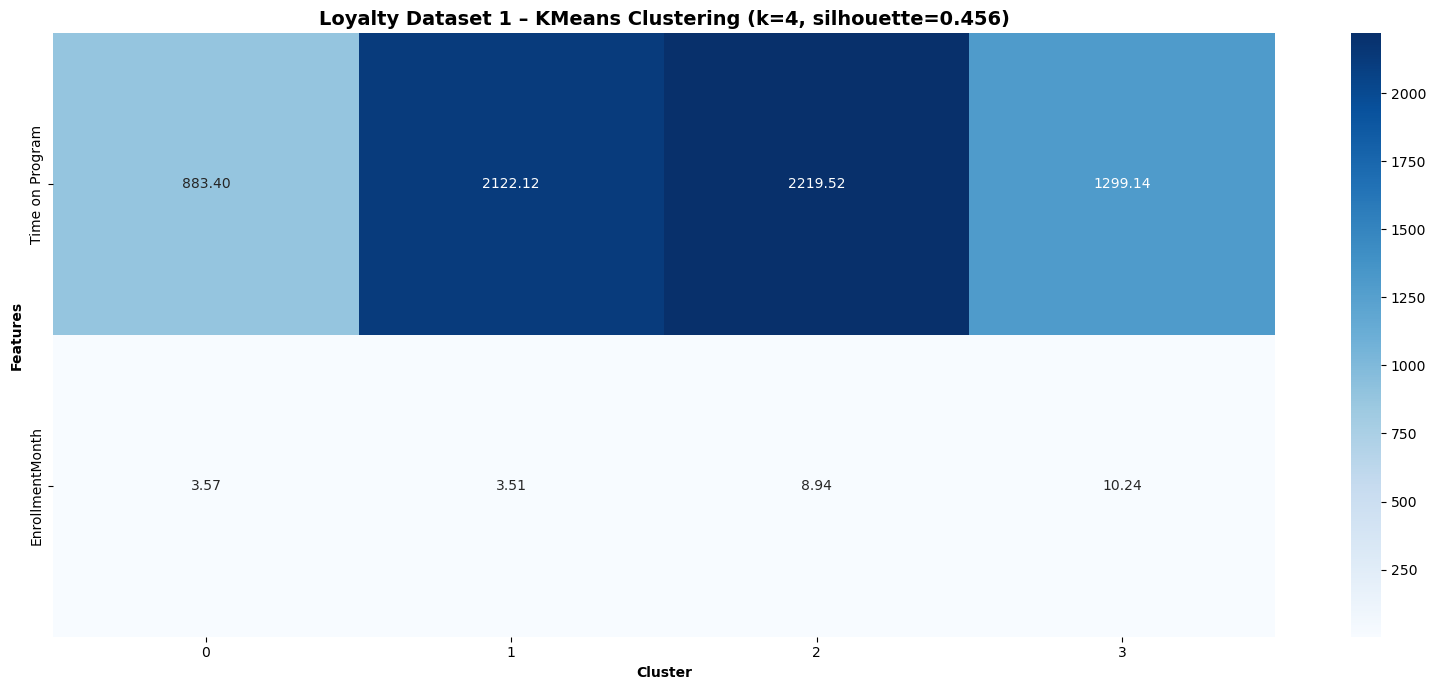

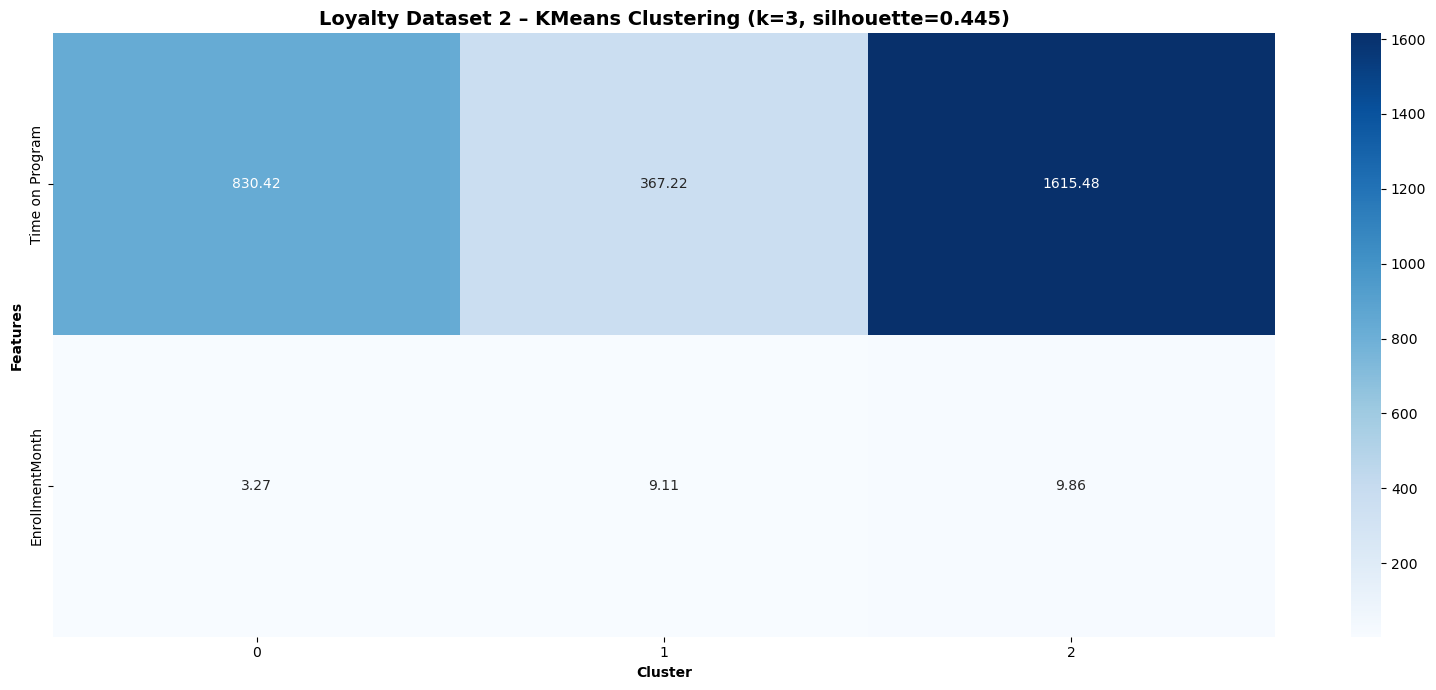

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def kmeans_best_k_profiling(df, cluster_range=range(2, 8), title_prefix=""):
    # Select numerical columns
    numerical_columns = df.select_dtypes(include=['int64', 'float64', 'int32']).columns.tolist()
    
    # Scale features
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(df[numerical_columns])

    best_k = None
    best_score = -1

    # Try different k values
    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_scaled)
        score = silhouette_score(X_scaled, labels)

        if score > best_score:
            best_score = score
            best_k = k

    # Fit KMeans with best k
    kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
    final_labels = kmeans_final.fit_predict(X_scaled)

    # Add cluster labels to normalized and original data
    df_normalized = df.copy()
    df_normalized['kmeans_cluster'] = final_labels

    df_original_scale = pd.DataFrame(
        scaler.inverse_transform(X_scaled),
        columns=numerical_columns,
        index=df.index
    )
    df_original_scale['kmeans_cluster'] = final_labels

    # Profile clusters
    cluster_profile = df_original_scale.groupby('kmeans_cluster')[numerical_columns].mean()

    # Heatmap visualization
    plt.figure(figsize=(16, 7))
    sns.heatmap(cluster_profile.T, cmap="Blues", annot=True, fmt=".2f")
    plt.title(
        f"{title_prefix} – KMeans Clustering (k={best_k}, silhouette={best_score:.3f})",
        fontweight="bold",
        fontsize=14
    )
    plt.xlabel("Cluster", fontweight="bold")
    plt.ylabel("Features", fontweight="bold")
    plt.tight_layout()
    plt.show()

    return df_normalized, cluster_profile, best_k, best_score

# Example usage for your datasets
loyalty_clustering1_normalized, cluster_profile1, best_k1, sil1 = kmeans_best_k_profiling(
    loyalty_clustering1,
    cluster_range=range(2, 8),
    title_prefix="Loyalty Dataset 1"
)

loyalty_clustering2_normalized, cluster_profile2, best_k2, sil2 = kmeans_best_k_profiling(
    loyalty_clustering2,
    cluster_range=range(2, 8),
    title_prefix="Loyalty Dataset 2"
)


In [99]:
# Percentage of rows in each cluster for Dataset 1
cluster_percent_1 = loyalty_clustering1_normalized['kmeans_cluster'].value_counts(normalize=True) * 100
print("Loyalty Dataset 1 cluster distribution (%):")
print(cluster_percent_1.sort_index())

# Percentage of rows in each cluster for Dataset 2
cluster_percent_2 = loyalty_clustering2_normalized['kmeans_cluster'].value_counts(normalize=True) * 100
print("\nLoyalty Dataset 2 cluster distribution (%):")
print(cluster_percent_2.sort_index())


Loyalty Dataset 1 cluster distribution (%):
kmeans_cluster
0    24.0
1    32.8
2    26.4
3    16.8
Name: proportion, dtype: float64

Loyalty Dataset 2 cluster distribution (%):
kmeans_cluster
0    47.2
1    36.0
2    16.8
Name: proportion, dtype: float64


In [100]:
FlightsDB_1['cluster1'] = loyalty_clustering1_normalized['kmeans_cluster']
FlightsDB_2['cluster2'] = loyalty_clustering2_normalized['kmeans_cluster']

In [101]:
pd.crosstab(FlightsDB_1['cluster1'], FlightsDB_1['Cancelled'])


Cancelled,N
cluster1,
0,30
1,41
2,33
3,21


In [102]:
pd.crosstab(FlightsDB_2['cluster2'], FlightsDB_1['Cancelled'])


Cancelled,N
cluster2,
0,59
1,45
2,21


In [103]:
pd.crosstab(
    FlightsDB_1['cluster1'],
    FlightsDB_1['Cancelled'],
    normalize='index'
) * 100


Cancelled,N
cluster1,
0,100.0
1,100.0
2,100.0
3,100.0


In [104]:
pd.crosstab(
    FlightsDB_2['cluster2'],
    FlightsDB_2['Cancelled'],
    normalize='index'
) * 100

Cancelled,N,Y
cluster2,,
0,96.610169,3.389831
1,97.777778,2.222222
2,100.000000,0.000000


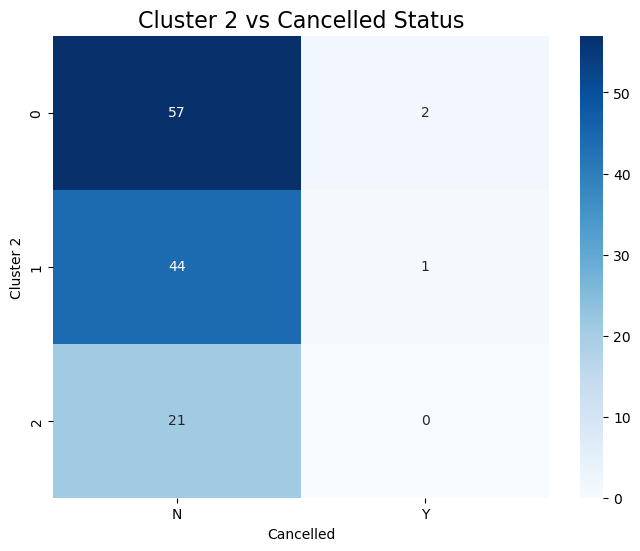

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create a crosstab of cluster2 vs Cancelled
cluster2_cancel_ct = pd.crosstab(
    FlightsDB_2['cluster2'], 
    FlightsDB_2['Cancelled']
)

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cluster2_cancel_ct, annot=True, fmt="d", cmap="Blues")
plt.title("Cluster 2 vs Cancelled Status", fontsize=16)
plt.xlabel("Cancelled")
plt.ylabel("Cluster 2")
plt.show()


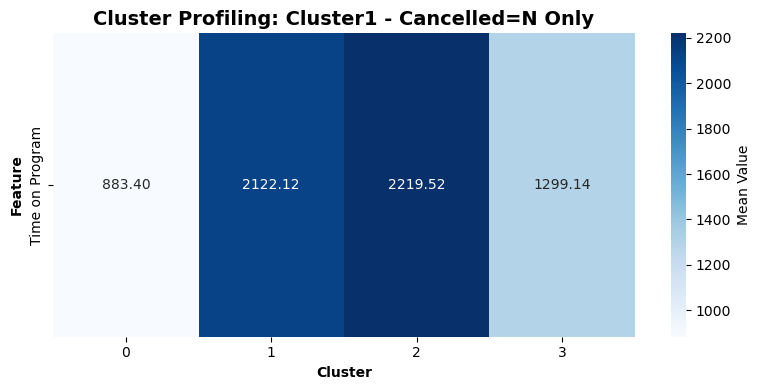


Customer Distribution (Cancelled='N' only - cluster1):
  Cluster 0: 30 customers (24.0%)
  Cluster 1: 41 customers (32.8%)
  Cluster 2: 33 customers (26.4%)
  Cluster 3: 21 customers (16.8%)


In [106]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Choose your dataset (replace with FlightsDB_1 or FlightsDB_2)
df_current = FlightsDB_1  # or FlightsDB_2

# Filter for Cancelled='N' only
df_not_cancelled = df_current[df_current['Cancelled'] == 'N'].copy()

# Keep only TimeOnProgram and cluster column
cluster_col = 'cluster1'  # or 'cluster_2'
features_to_analyze = ['Time on Program']

# Calculate mean per cluster for non-cancelled customers
cluster_profile = df_not_cancelled.groupby(cluster_col)[features_to_analyze].mean()

# Visualize heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(cluster_profile.T, cmap="Blues", annot=True, fmt=".2f", cbar_kws={'label': 'Mean Value'})
plt.title(f"Cluster Profiling: {cluster_col.replace('_', ' ').title()} - Cancelled=N Only", 
          fontweight='bold', fontsize=14)
plt.xlabel("Cluster", fontweight='bold')
plt.ylabel("Feature", fontweight='bold')
plt.tight_layout()
plt.show()

# Print customer counts per cluster for Cancelled='N'
print(f"\nCustomer Distribution (Cancelled='N' only - {cluster_col}):")
cluster_counts = df_not_cancelled[cluster_col].value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    pct = (count / len(df_not_cancelled)) * 100
    print(f"  Cluster {cluster_id}: {count:,} customers ({pct:.1f}%)")


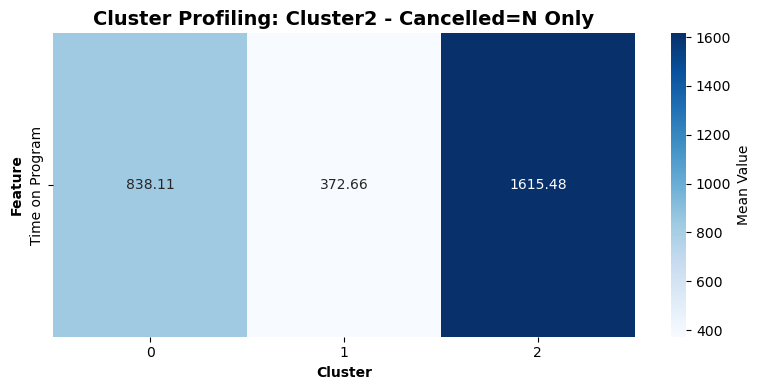


Customer Distribution (Cancelled='N' only - cluster2):
  Cluster 0: 57 customers (46.7%)
  Cluster 1: 44 customers (36.1%)
  Cluster 2: 21 customers (17.2%)


In [107]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_current = FlightsDB_2  # 

# Filter for Cancelled='N' only
df_not_cancelled = df_current[df_current['Cancelled'] == 'N'].copy()

# Keep only TimeOnProgram and cluster column
cluster_col = 'cluster2'  # or 'cluster_2'
features_to_analyze = ['Time on Program']

# Calculate mean per cluster for non-cancelled customers
cluster_profile = df_not_cancelled.groupby(cluster_col)[features_to_analyze].mean()

# Visualize heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(cluster_profile.T, cmap="Blues", annot=True, fmt=".2f", cbar_kws={'label': 'Mean Value'})
plt.title(f"Cluster Profiling: {cluster_col.replace('_', ' ').title()} - Cancelled=N Only", 
          fontweight='bold', fontsize=14)
plt.xlabel("Cluster", fontweight='bold')
plt.ylabel("Feature", fontweight='bold')
plt.tight_layout()
plt.show()

# Print customer counts per cluster for Cancelled='N'
print(f"\nCustomer Distribution (Cancelled='N' only - {cluster_col}):")
cluster_counts = df_not_cancelled[cluster_col].value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    pct = (count / len(df_not_cancelled)) * 100
    print(f"  Cluster {cluster_id}: {count:,} customers ({pct:.1f}%)")


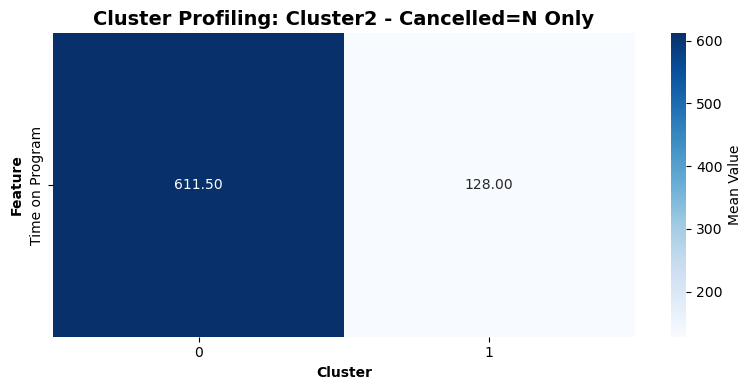


Customer Distribution (Cancelled='N' only - cluster2):
  Cluster 0: 2 customers (66.7%)
  Cluster 1: 1 customers (33.3%)


In [108]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_current = FlightsDB_2  # 

# Filter for Cancelled='N' only
df_not_cancelled = df_current[df_current['Cancelled'] == 'Y'].copy()

# Keep only TimeOnProgram and cluster column
cluster_col = 'cluster2'  # or 'cluster_2'
features_to_analyze = ['Time on Program']

# Calculate mean per cluster for non-cancelled customers
cluster_profile = df_not_cancelled.groupby(cluster_col)[features_to_analyze].mean()

# Visualize heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(cluster_profile.T, cmap="Blues", annot=True, fmt=".2f", cbar_kws={'label': 'Mean Value'})
plt.title(f"Cluster Profiling: {cluster_col.replace('_', ' ').title()} - Cancelled=N Only", 
          fontweight='bold', fontsize=14)
plt.xlabel("Cluster", fontweight='bold')
plt.ylabel("Feature", fontweight='bold')
plt.tight_layout()
plt.show()

# Print customer counts per cluster for Cancelled='N'
print(f"\nCustomer Distribution (Cancelled='N' only - {cluster_col}):")
cluster_counts = df_not_cancelled[cluster_col].value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    pct = (count / len(df_not_cancelled)) * 100
    print(f"  Cluster {cluster_id}: {count:,} customers ({pct:.1f}%)")


## Value Based perspective

VIP outliers: 5 | Core customers: 120
Clusters=2 | Silhouette=0.281
Clusters=3 | Silhouette=0.352
Clusters=4 | Silhouette=0.389
Clusters=5 | Silhouette=0.347
Clusters=6 | Silhouette=0.355
Clusters=7 | Silhouette=0.361


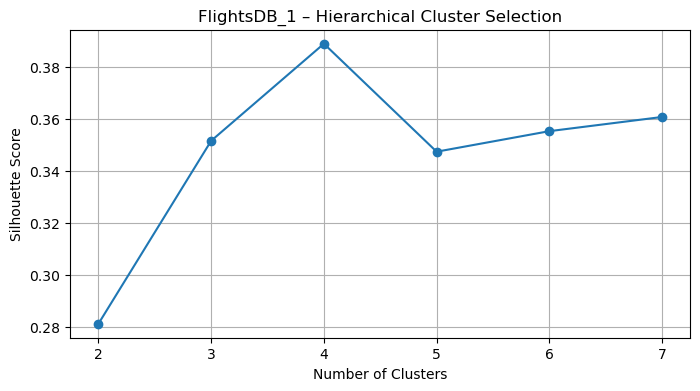

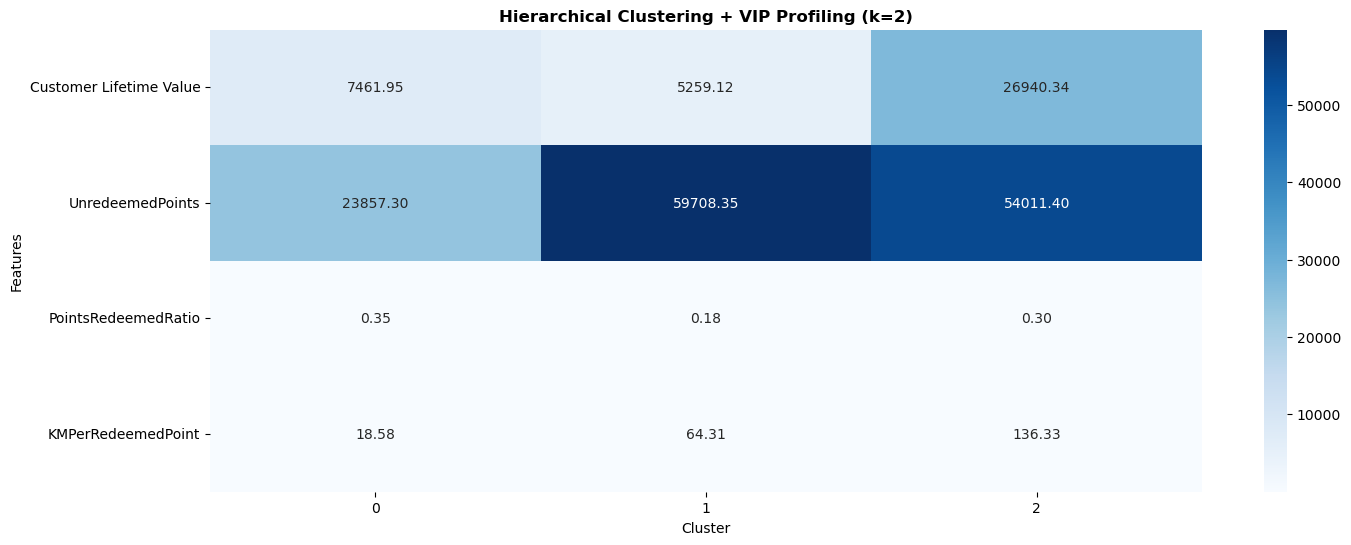

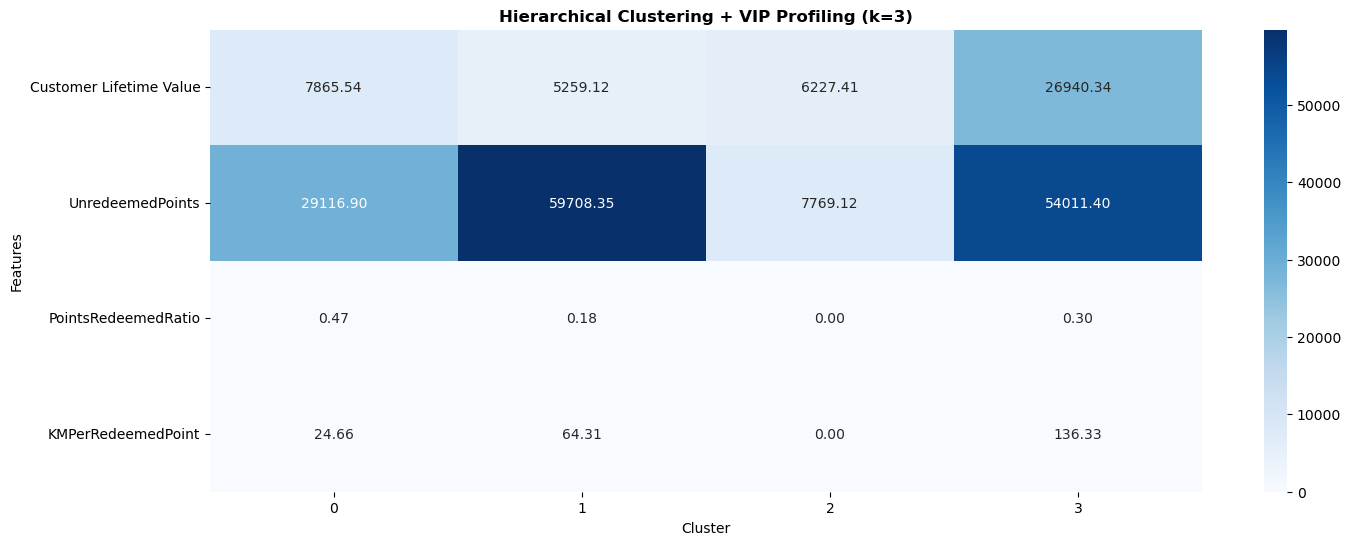

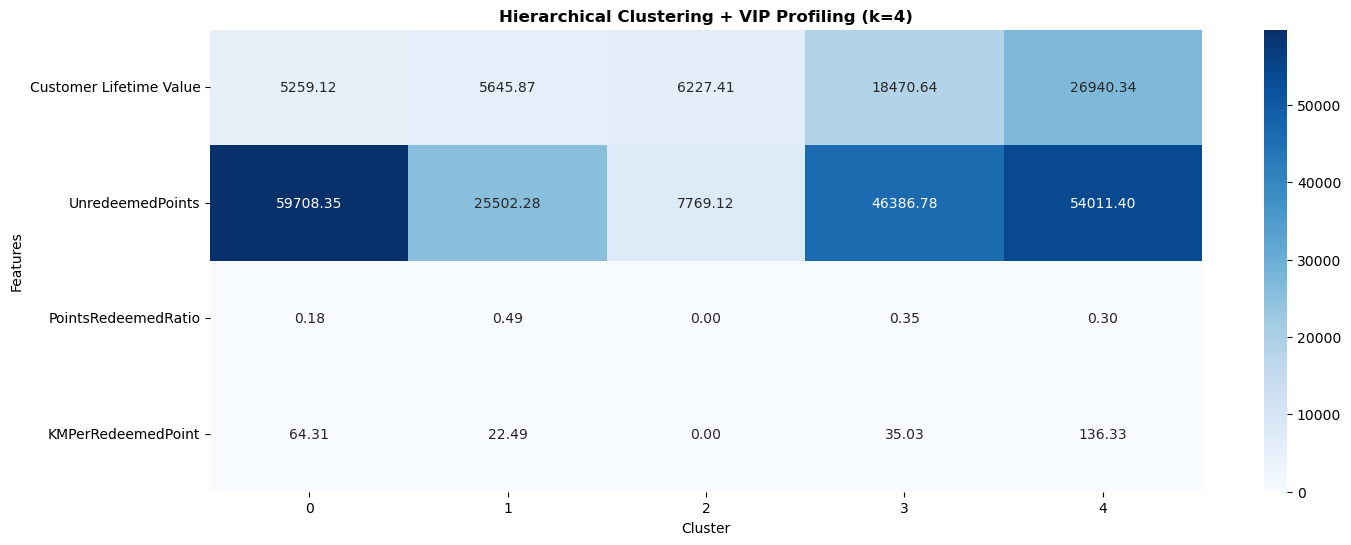

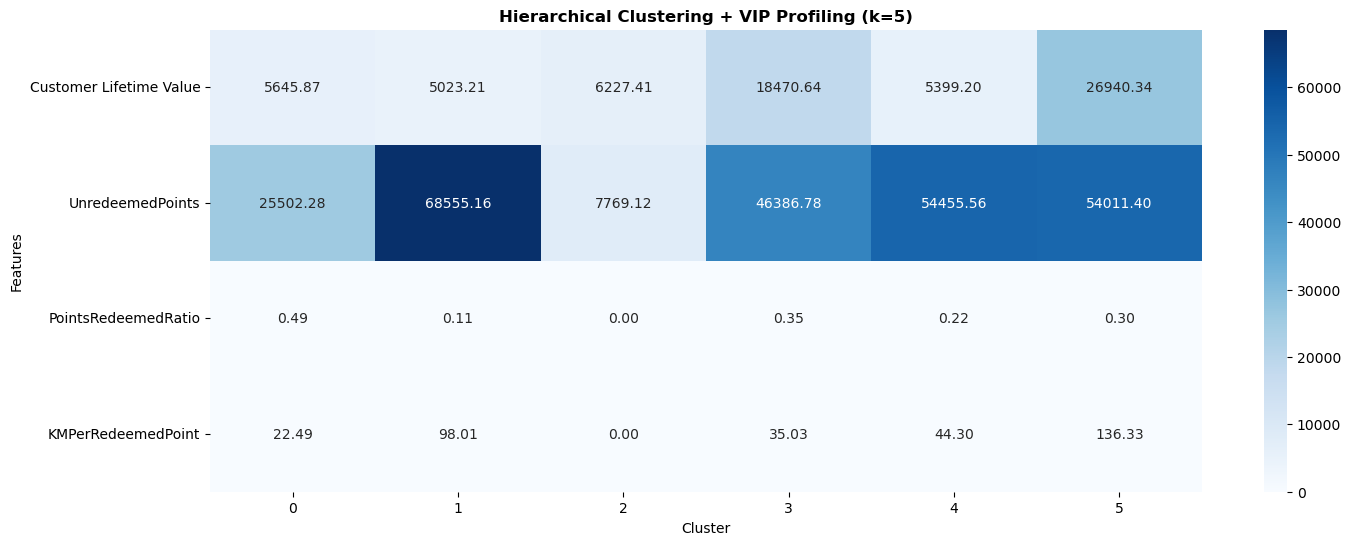

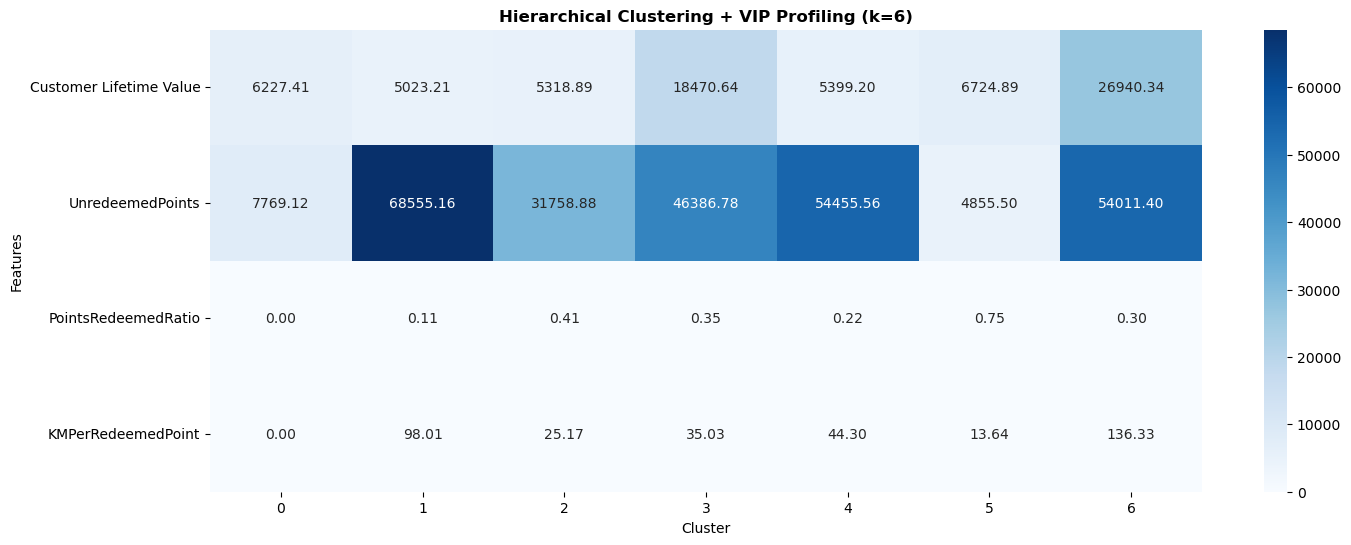

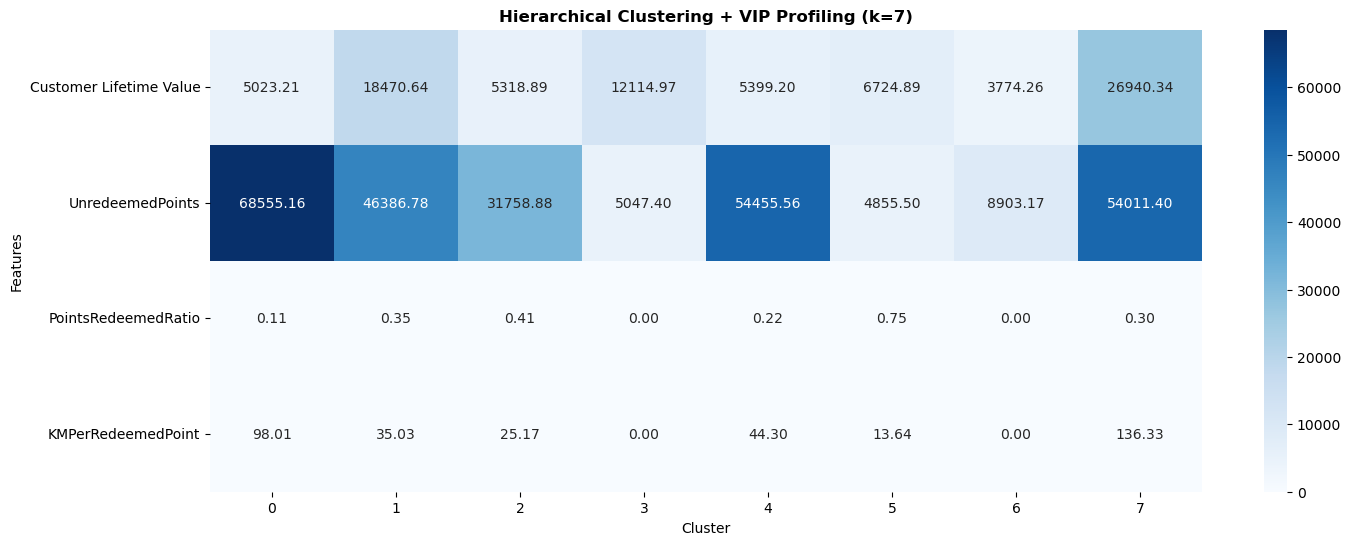

VIP outliers: 4 | Core customers: 121
Clusters=2 | Silhouette=0.302
Clusters=3 | Silhouette=0.344
Clusters=4 | Silhouette=0.368
Clusters=5 | Silhouette=0.363
Clusters=6 | Silhouette=0.350
Clusters=7 | Silhouette=0.365


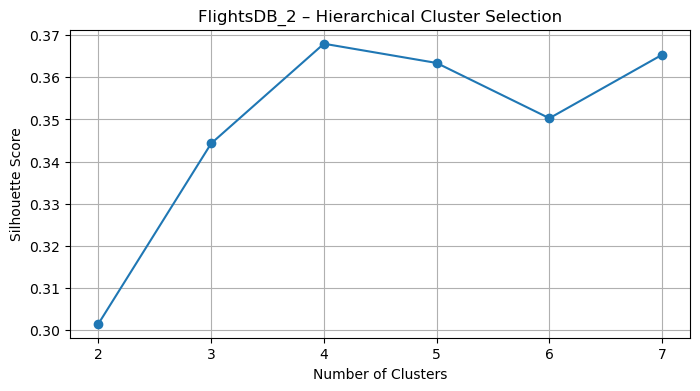

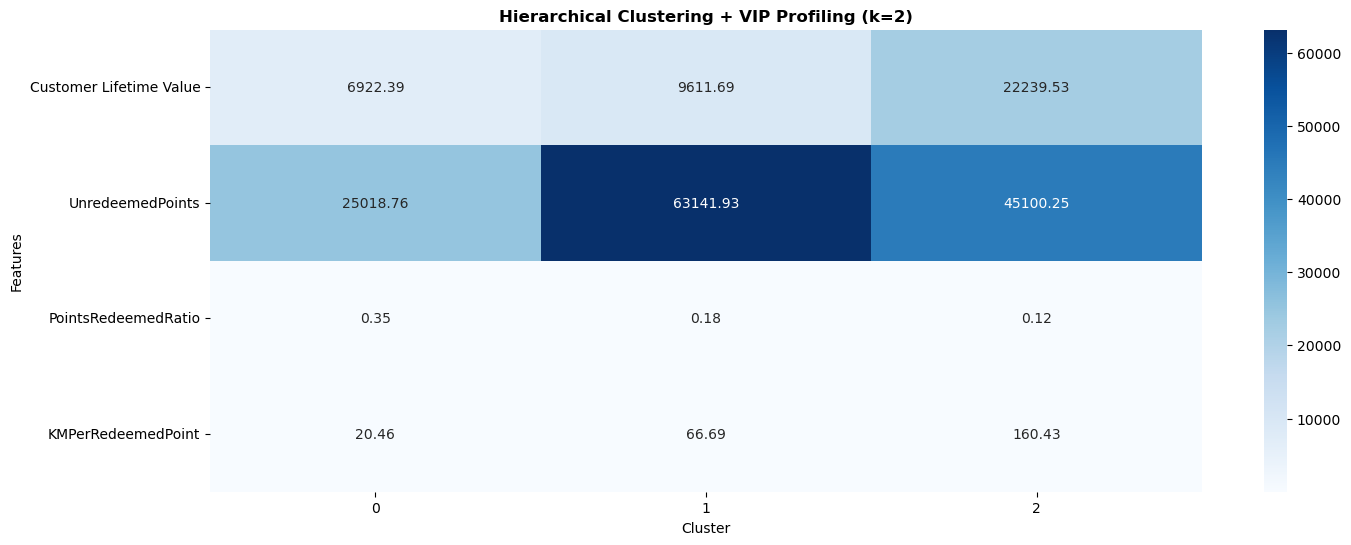

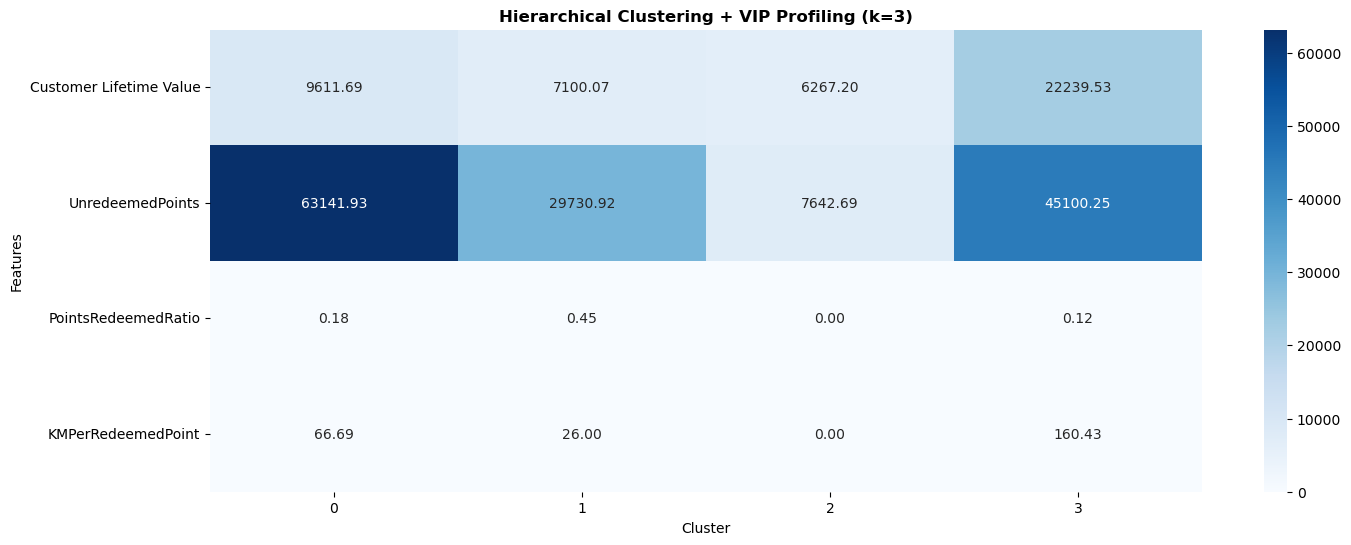

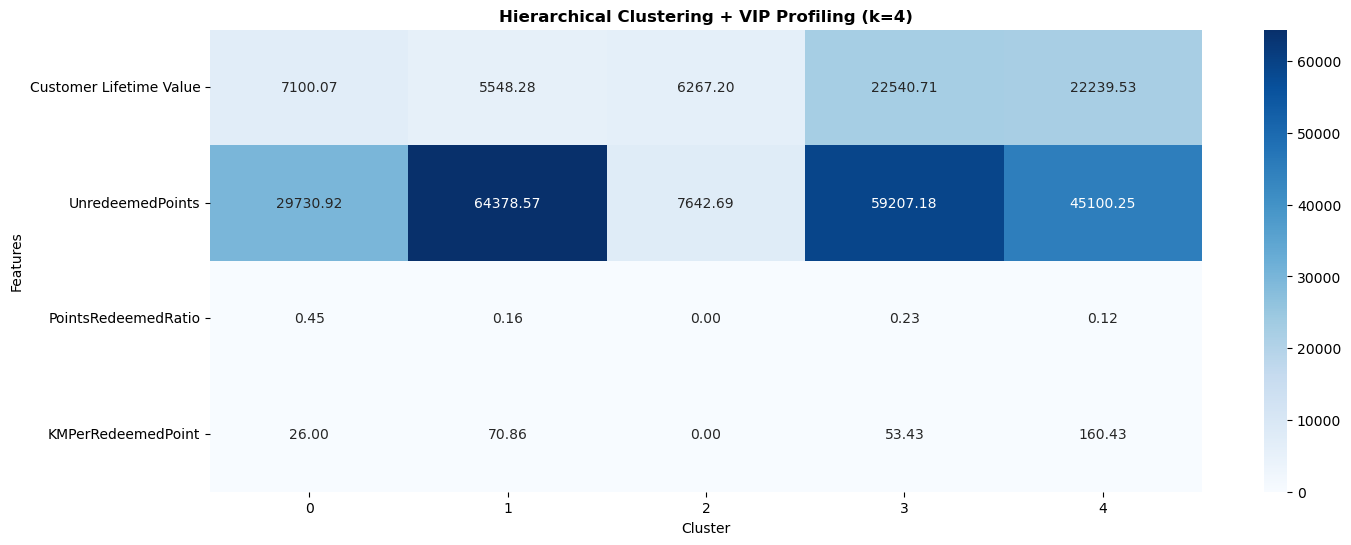

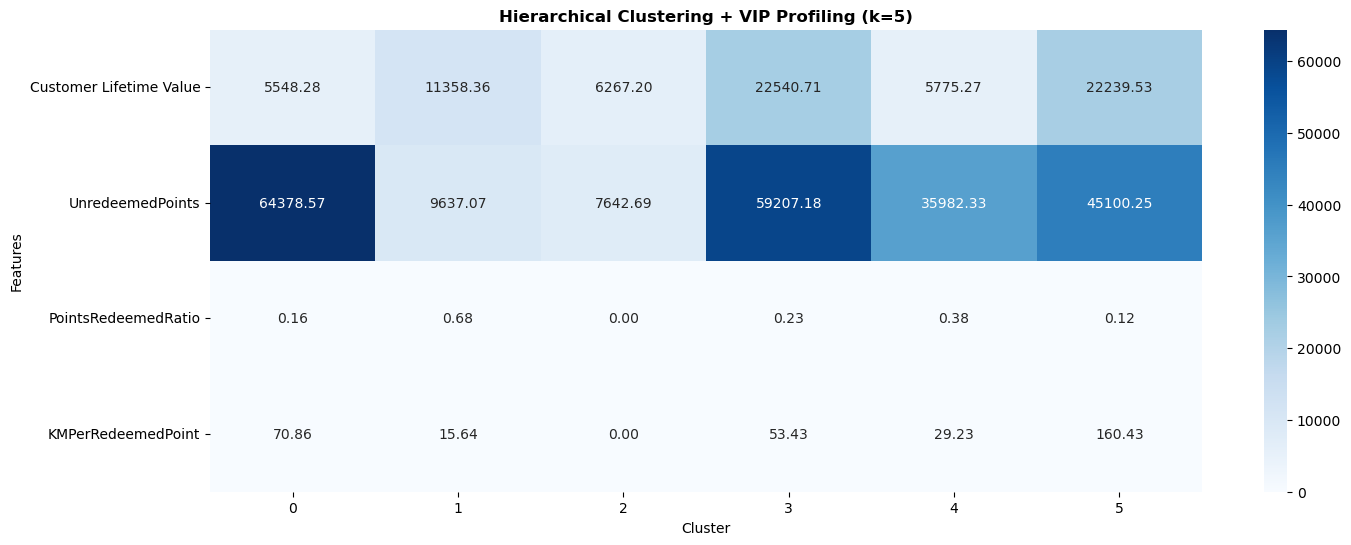

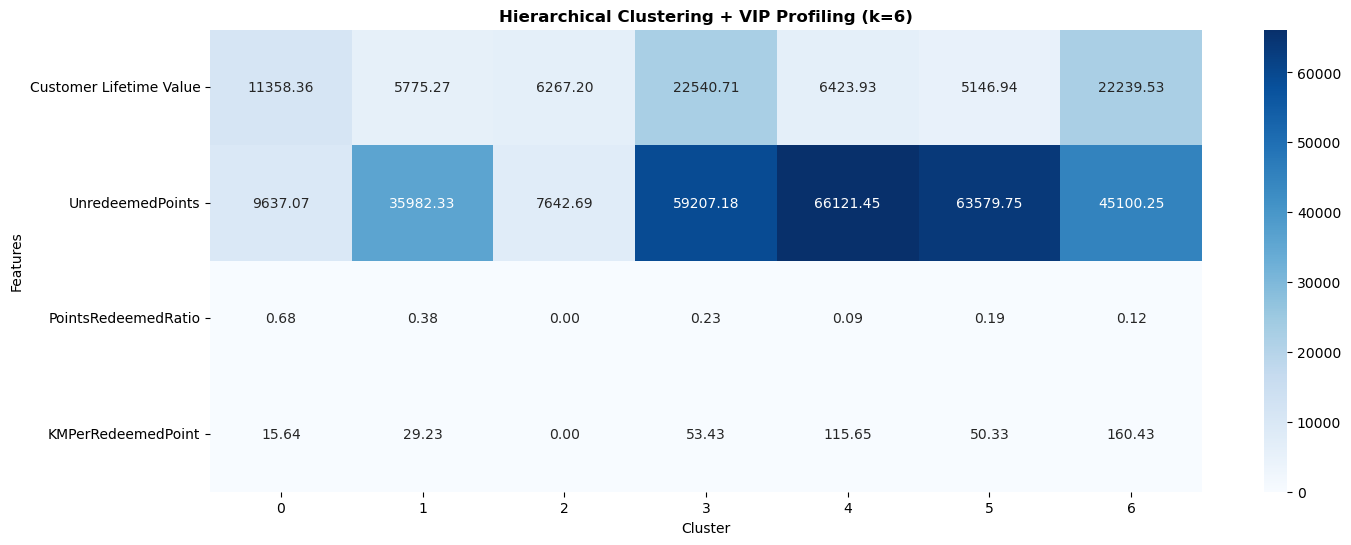

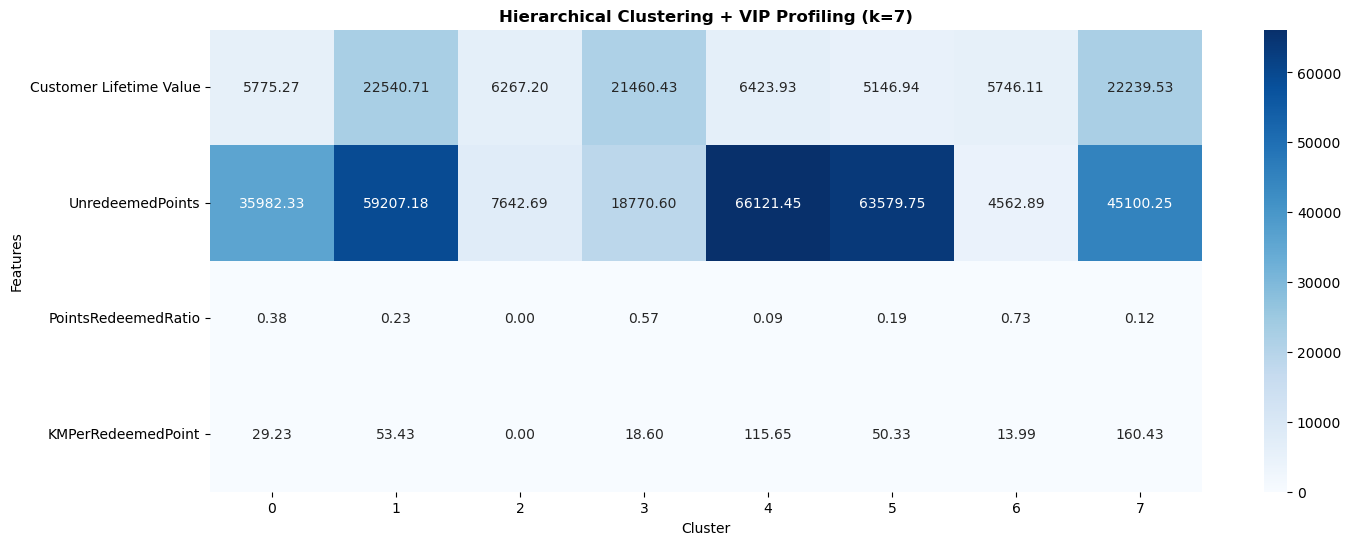

In [109]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt


value_features = [
    'Customer Lifetime Value',
    'UnredeemedPoints',
    'PointsRedeemedRatio',
    'KMPerRedeemedPoint'
]

def detect_vip_outliers(df, features, eps=2.0, min_samples=20):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[features])

    dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
    labels = dbscan.fit_predict(X_scaled)

    df_core = df[labels != -1].copy()
    df_vip = df[labels == -1].copy()

    print(f"VIP outliers: {len(df_vip)} | Core customers: {len(df_core)}")
    return df_core, df_vip


def hierarchical_cluster_comparison(df_core, features, cluster_range):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_core[features])

    results = []
    for k in cluster_range:
        hc = AgglomerativeClustering(
            n_clusters=k,
            linkage='ward',
            metric='euclidean'
        )
        labels = hc.fit_predict(X_scaled)
        sil = silhouette_score(X_scaled, labels)

        results.append((k, sil))
        print(f"Clusters={k} | Silhouette={sil:.3f}")

    return pd.DataFrame(results, columns=['n_clusters', 'silhouette_score'])


def hierarchical_profiles(df_core, df_vip, features, cluster_range):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_core[features])

    for k in cluster_range:
        hc = AgglomerativeClustering(
            n_clusters=k,
            linkage='ward',
            metric='euclidean'
        )
        labels = hc.fit_predict(X_scaled)

        df_core_tmp = df_core.copy()
        df_core_tmp['hierarchical_cluster'] = labels

        df_vip_tmp = df_vip.copy()
        df_vip_tmp['hierarchical_cluster'] = k

        df_all = pd.concat([df_core_tmp, df_vip_tmp], ignore_index=True)
        profile = df_all.groupby('hierarchical_cluster')[features].mean()

        plt.figure(figsize=(16, 6))
        sns.heatmap(profile.T, annot=True, fmt=".2f", cmap="Blues")
        plt.title(f"Hierarchical Clustering + VIP Profiling (k={k})", fontweight="bold")
        plt.xlabel("Cluster")
        plt.ylabel("Features")
        plt.show()



cluster_range = range(2, 8)

core1, vip1 = detect_vip_outliers(FlightsDB_1, value_features)

comparison1 = hierarchical_cluster_comparison(
    core1,
    value_features,
    cluster_range
)

plt.figure(figsize=(8, 4))
plt.plot(comparison1['n_clusters'], comparison1['silhouette_score'], marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("FlightsDB_1 – Hierarchical Cluster Selection")
plt.grid(True)
plt.show()

hierarchical_profiles(
    core1,
    vip1,
    value_features,
    cluster_range
)


core2, vip2 = detect_vip_outliers(FlightsDB_2, value_features)

comparison2 = hierarchical_cluster_comparison(
    core2,
    value_features,
    cluster_range
)

plt.figure(figsize=(8, 4))
plt.plot(comparison2['n_clusters'], comparison2['silhouette_score'], marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("FlightsDB_2 – Hierarchical Cluster Selection")
plt.grid(True)
plt.show()

hierarchical_profiles(
    core2,
    vip2,
    value_features,
    cluster_range
)


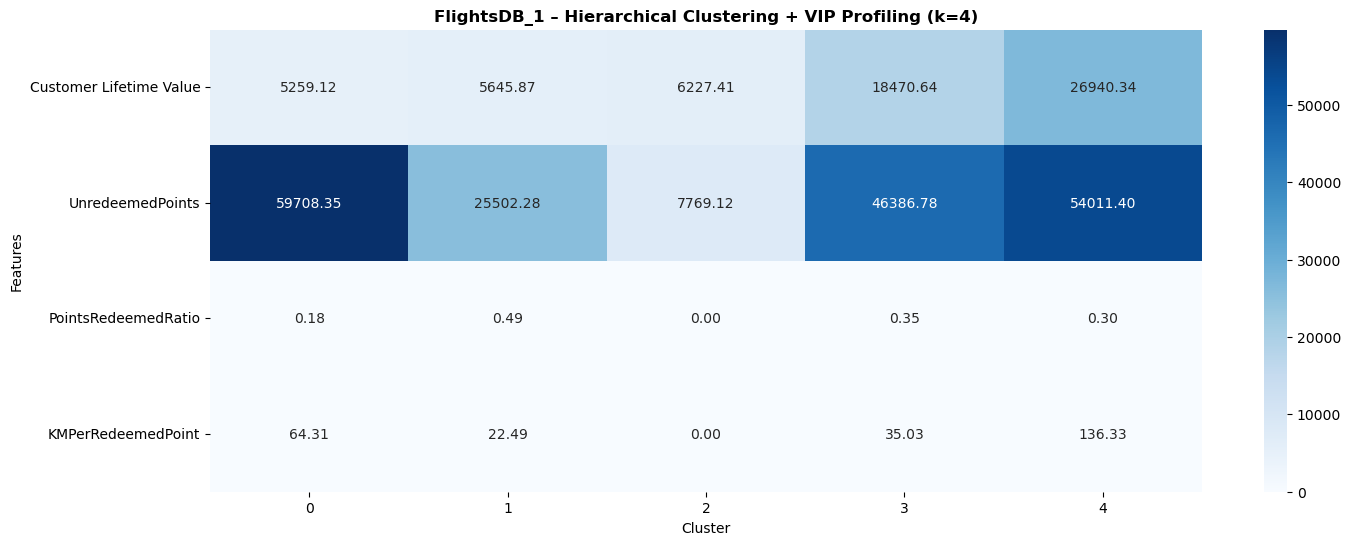

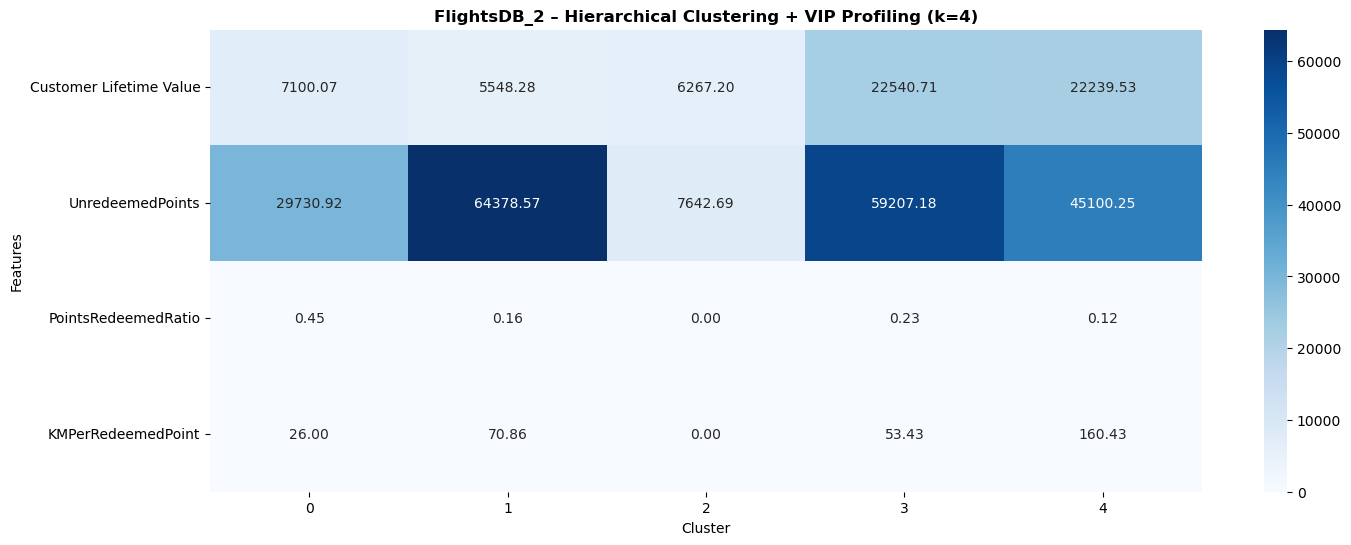

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt

value_features = [
    'Customer Lifetime Value',
    'UnredeemedPoints',
    'PointsRedeemedRatio',
    'KMPerRedeemedPoint'
]

cluster_range = range(2, 8)

def detect_vip_outliers(df, features, eps=2.0, min_samples=20):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[features])
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
    labels = dbscan.fit_predict(X_scaled)
    df_core = df[labels != -1].copy()
    df_vip = df[labels == -1].copy()
    return df_core, df_vip

def choose_best_k(df_core, features, cluster_range):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_core[features])
    best_k = None
    best_score = -1
    for k in cluster_range:
        hc = AgglomerativeClustering(
            n_clusters=k,
            linkage='ward',
            metric='euclidean'
        )
        labels = hc.fit_predict(X_scaled)
        score = silhouette_score(X_scaled, labels)
        if score > best_score:
            best_score = score
            best_k = k
    return best_k

def hierarchical_clustering_and_profiling(df_core, df_vip, features, best_k, title_prefix):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_core[features])
    hc = AgglomerativeClustering(
        n_clusters=best_k,
        linkage='ward',
        metric='euclidean'
    )
    labels = hc.fit_predict(X_scaled)
    df_core['hierarchical_cluster'] = labels
    df_vip['hierarchical_cluster'] = best_k
    df_all = pd.concat([df_core, df_vip], ignore_index=True)
    profile = df_all.groupby('hierarchical_cluster')[features].mean()
    plt.figure(figsize=(16, 6))
    sns.heatmap(profile.T, annot=True, fmt=".2f", cmap="Blues")
    plt.title(f"{title_prefix} – Hierarchical Clustering + VIP Profiling (k={best_k})", fontweight="bold")
    plt.xlabel("Cluster")
    plt.ylabel("Features")
    plt.show()
    return df_all, profile

core1, vip1 = detect_vip_outliers(FlightsDB_1, value_features)
best_k1 = choose_best_k(core1, value_features, cluster_range)
df1_all, profile1 = hierarchical_clustering_and_profiling(
    core1, vip1, value_features, best_k1, "FlightsDB_1"
)

core2, vip2 = detect_vip_outliers(FlightsDB_2, value_features)
best_k2 = choose_best_k(core2, value_features, cluster_range)
df2_all, profile2 = hierarchical_clustering_and_profiling(
    core2, vip2, value_features, best_k2, "FlightsDB_2"
)


In [ ]:
# Function to calculate cluster percentages
def cluster_percentages(df, cluster_col='hierarchical_cluster'):
    cluster_counts = df[cluster_col].value_counts().sort_index()
    cluster_percent = (cluster_counts / len(df) * 100).round(2)
    return cluster_percent

# For FlightsDB_1
percentages1 = cluster_percentages(df1_all)
print("FlightsDB_1 cluster percentages:")
print(percentages1)

# For FlightsDB_2
percentages2 = cluster_percentages(df2_all)
print("\nFlightsDB_2 cluster percentages:")
print(percentages2)



FlightsDB_1 cluster percentages:
hierarchical_cluster
0    40.8
1    34.4
2    13.6
3     7.2
4     4.0
Name: count, dtype: float64

FlightsDB_2 cluster percentages:
hierarchical_cluster
0    47.2
1    28.0
2    12.8
3     8.8
4     3.2
Name: count, dtype: float64


,Loyalty#,PointsRedeemedRatio,FlightsWithCompanionsRatio,AvgDistancePerFlight,KMPerRedeemedPoint,UnredeemedPoints,HasBonus,AvgMonthlyFlights,sr_jan,sr_feb,...,EnrollmentDateOpening,CancellationDate,Customer Lifetime Value,EnrollmentType,Cancelled,Time on Program,EnrollmentMonth,Reenroll,cluster1,hierarchical_cluster
0,101902,0.182369,0.176966,2131.451124,54.850123,62023,0,5.741935,0.016854,0.022472,...,2020-01-07,0,6265.34,Standard,N,723,1,0,0,0
1,106001,0.395167,0.241814,2039.651889,25.313924,48960,0,5.591549,0.093199,0.110831,...,2015-07-16,0,12168.74,Standard,N,2359,7,0,2,3
2,130331,0.202501,0.426230,2851.959016,49.395088,27741,0,2.595745,0.000000,0.032787,...,2019-12-01,0,2862.73,Standard,N,760,12,0,3,0
3,135421,0.141525,0.328947,2590.785197,70.674686,67598,0,4.676923,0.055921,0.069079,...,2017-12-16,0,5304.54,Standard,N,1475,12,0,3,0
4,193662,0.165237,0.168182,2150.022500,60.536885,78946,0,6.470588,0.004545,0.054545,...,2015-05-07,0,3844.57,Standard,N,2429,5,0,1,0


## Seasonal Perspective

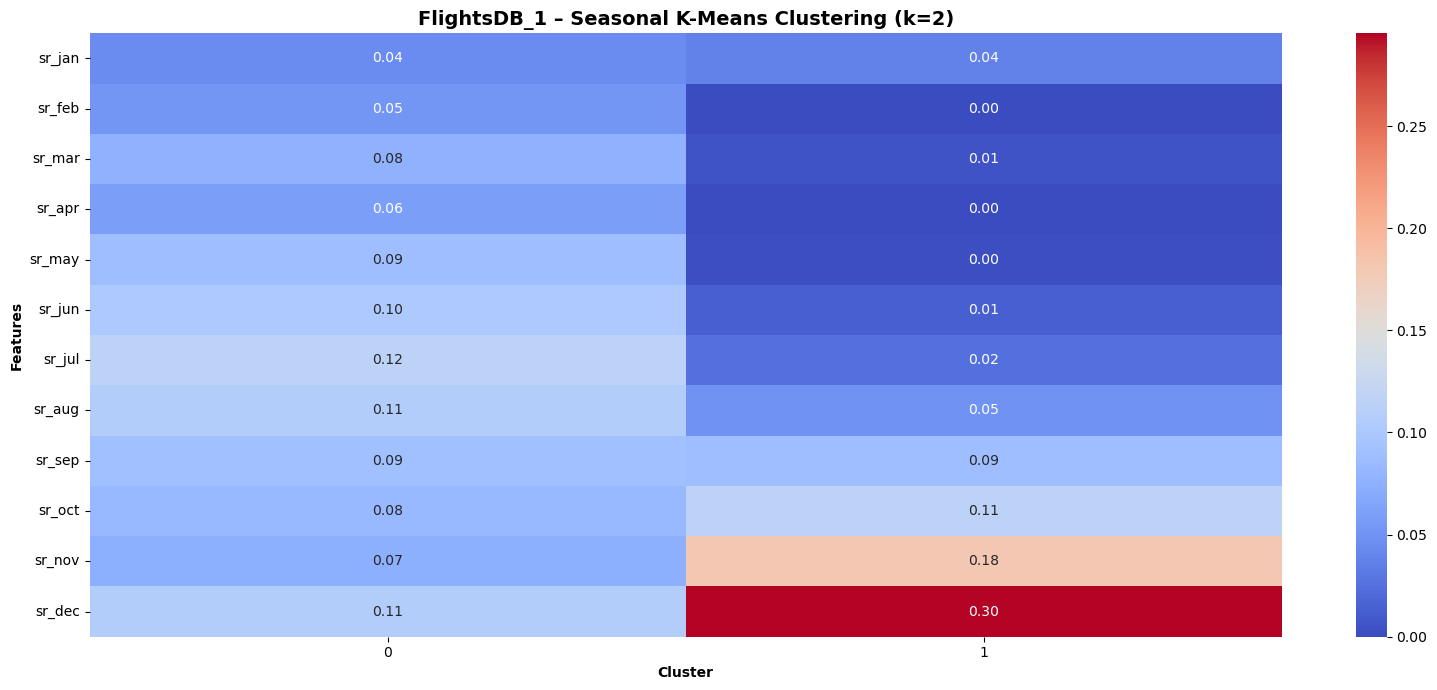

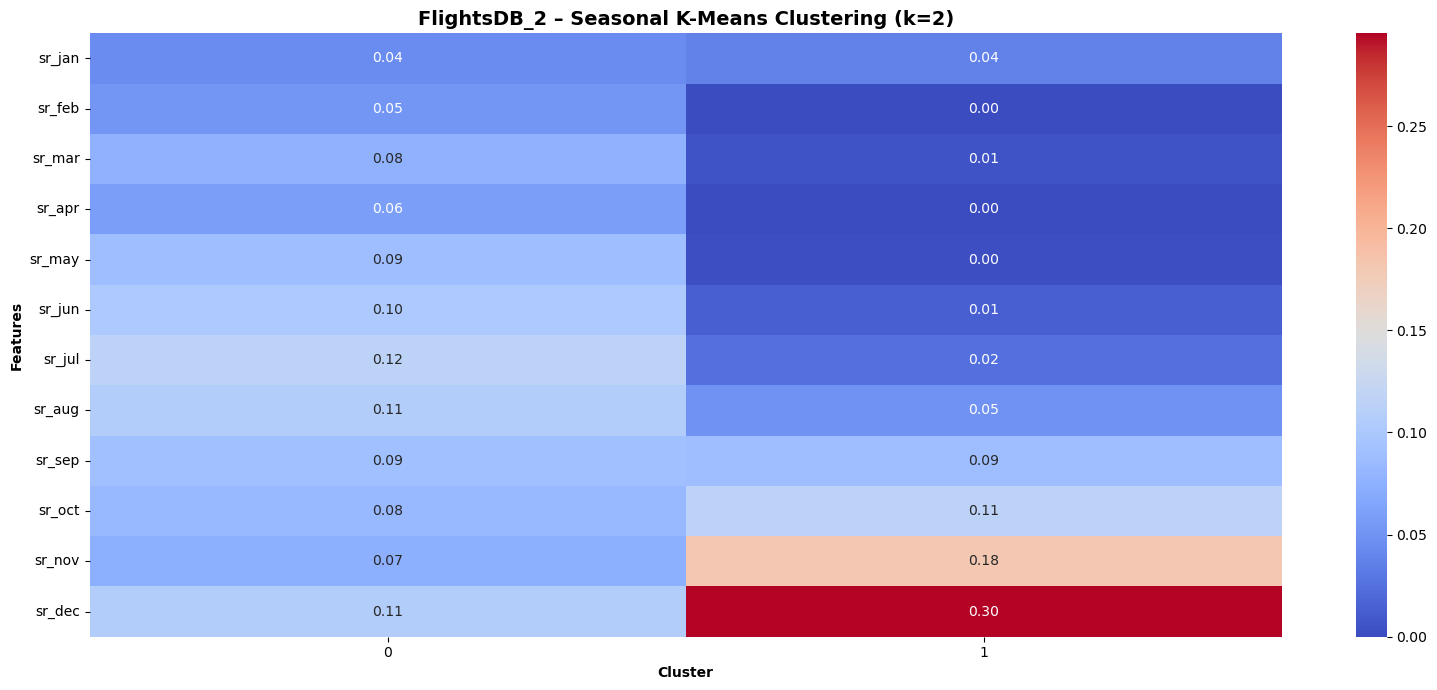

In [111]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt

def seasonal_features(df):
    sr_features = [col for col in df.columns if col.startswith('sr_')]
    return sr_features

def choose_best_k_kmeans(df, features, cluster_range):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[features])
    best_k = None
    best_score = -1
    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_scaled)
        score = silhouette_score(X_scaled, labels)
        if score > best_score:
            best_score = score
            best_k = k
    return best_k

def kmeans_seasonal_clustering(df, features, best_k, title_prefix):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[features])
    kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
    df['seasonal_cluster'] = kmeans.fit_predict(X_scaled)
    profile = df.groupby('seasonal_cluster')[features].mean()
    plt.figure(figsize=(16, 7))
    sns.heatmap(profile.T, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title(f"{title_prefix} – Seasonal K-Means Clustering (k={best_k})", fontweight='bold', fontsize=14)
    plt.xlabel("Cluster", fontweight='bold')
    plt.ylabel("Features", fontweight='bold')
    plt.tight_layout()
    plt.show()
    return df, profile

cluster_range = range(2, 8)

sr_features1 = seasonal_features(FlightsDB_1)
best_k1 = choose_best_k_kmeans(FlightsDB_1, sr_features1, cluster_range)
FlightsDB_1, seasonal_profile1 = kmeans_seasonal_clustering(
    FlightsDB_1, sr_features1, best_k1, "FlightsDB_1"
)

sr_features2 = seasonal_features(FlightsDB_2)
best_k2 = choose_best_k_kmeans(FlightsDB_2, sr_features2, cluster_range)
FlightsDB_2, seasonal_profile2 = kmeans_seasonal_clustering(
    FlightsDB_2, sr_features2, best_k2, "FlightsDB_2"
)


In [112]:
# Cluster Profiling for FlightsDB_1
print("=== FlightsDB_1 Seasonal Cluster Profiling ===")
cluster_counts1 = FlightsDB_1['seasonal_cluster'].value_counts().sort_index()
cluster_profile1 = FlightsDB_1.groupby('seasonal_cluster')[sr_features1].mean()
cluster_profile1['Count'] = cluster_counts1
cluster_profile1['Proportion'] = cluster_profile1['Count'] / cluster_profile1['Count'].sum()

display(cluster_profile1.style.format("{:.2f}"))


=== FlightsDB_1 Seasonal Cluster Profiling ===


,sr_jan,sr_feb,sr_mar,sr_apr,sr_may,sr_jun,sr_jul,sr_aug,sr_sep,sr_oct,sr_nov,sr_dec,Count,Proportion
seasonal_cluster,,,,,,,,,,,,,,
0,0.04,0.05,0.08,0.06,0.09,0.10,0.12,0.11,0.09,0.08,0.07,0.11,98.00,0.78
1,0.04,0.00,0.01,0.00,0.00,0.01,0.02,0.05,0.09,0.11,0.18,0.30,27.00,0.22


In [113]:
# Cluster Profiling for FlightsDB_2
print("=== FlightsDB_2 Seasonal Cluster Profiling ===")
cluster_counts2 = FlightsDB_2['seasonal_cluster'].value_counts().sort_index()
cluster_profile2 = FlightsDB_2.groupby('seasonal_cluster')[sr_features2].mean()
cluster_profile2['Count'] = cluster_counts2
cluster_profile2['Proportion'] = cluster_profile2['Count'] / cluster_profile2['Count'].sum()

display(cluster_profile2.style.format("{:.2f}"))


=== FlightsDB_2 Seasonal Cluster Profiling ===


,sr_jan,sr_feb,sr_mar,sr_apr,sr_may,sr_jun,sr_jul,sr_aug,sr_sep,sr_oct,sr_nov,sr_dec,Count,Proportion
seasonal_cluster,,,,,,,,,,,,,,
0,0.04,0.05,0.08,0.06,0.09,0.10,0.12,0.11,0.09,0.08,0.07,0.11,98.00,0.78
1,0.04,0.00,0.01,0.00,0.00,0.01,0.02,0.05,0.09,0.11,0.18,0.30,27.00,0.22


## Merging perspectives

### Loyalty + Value Based Perspective

In [117]:
FlightsDB_1.head()
FlightsDB_1['hierarchical_cluster'] = df1_all['hierarchical_cluster']
FlightsDB_1 = FlightsDB_1.drop(columns='seasonal_cluster')

FlightsDB_2.head()
FlightsDB_2['hierarchical_cluster'] = df2_all['hierarchical_cluster']
FlightsDB_2 = FlightsDB_2.drop(columns='seasonal_cluster')

In [121]:
FlightsDB_1_no_vip = FlightsDB_1[FlightsDB_1['hierarchical_cluster'] == 4].copy()
FlightsDB_1 = FlightsDB_1[FlightsDB_1['hierarchical_cluster'] != 4].copy()

FlightsDB_1.head()

FlightsDB_2_no_vip = FlightsDB_2[FlightsDB_2['hierarchical_cluster'] == 4].copy()
FlightsDB_2 = FlightsDB_2[FlightsDB_2['hierarchical_cluster'] != 4].copy()

FlightsDB_2.head()

,Loyalty#,PointsRedeemedRatio,FlightsWithCompanionsRatio,AvgDistancePerFlight,KMPerRedeemedPoint,UnredeemedPoints,HasBonus,AvgMonthlyFlights,sr_jan,sr_feb,...,EnrollmentDateOpening,CancellationDate,Customer Lifetime Value,EnrollmentType,Cancelled,Time on Program,EnrollmentMonth,Reenroll,cluster2,hierarchical_cluster
0,101902,0.182369,0.176966,2131.451124,54.850123,62023,0,5.741935,0.016854,0.022472,...,2020-03-19,0,8609.16,Standard,N,624,3,0,0,1
1,106001,0.395167,0.241814,2039.651889,25.313924,48960,0,5.591549,0.093199,0.110831,...,2016-01-11,0,4914.04,Standard,N,2153,1,0,0,0
2,114414,0.034855,0.205776,2782.755957,286.978183,74377,0,3.957143,0.090253,0.126354,...,2015-12-18,0,2617.70,Standard,N,2177,12,0,2,0
3,130331,0.202501,0.426230,2851.959016,49.395088,27741,0,2.595745,0.000000,0.032787,...,2021-01-28,0,11638.90,Standard,N,309,1,0,0,3
4,135421,0.141525,0.328947,2590.785197,70.674686,67598,0,4.676923,0.055921,0.069079,...,2020-01-07,0,17441.64,Standard,N,696,1,0,0,1


In [122]:
# VB_col is the list of columns related to value-based perspective
VB_col = [

    'Customer Lifetime Value',
    'UnredeemedPoints',
    'PointsRedeemedRatio',
    'KMPerRedeemedPoint'
]

LO_col = [ 'Time on Program', 'EnrollmentMonth']

In [123]:
# Centroids of the concatenated cluster labels
df1_centroids = FlightsDB_1.groupby(['hierarchical_cluster', 'cluster1'])\
    [VB_col + LO_col].mean()
df1_centroids

Customer Lifetime Value  UnredeemedPoints  \
hierarchical_cluster cluster1                                              
0                    0                     7813.240833      33099.583333   
                     1                     6323.253750      38658.562500   
                     2                     6202.343846      54802.076923   
                     3                     5069.325000      49549.100000   
1                    0                     6774.594545      19306.818182   
                     1                    10260.161333      48979.533333   
                     2                     7544.958333      40213.250000   
                     3                     9725.388000      32275.800000   
2                    0                    12075.430000      37271.800000   
                     1                     4501.300000      51761.000000   
                     2                     5630.370000      41344.000000   
                     3                     4609.865000        555.500000   
3                    0                     2487.730000      20304.000000   
                     1                     2644.680000      26581.000000   
                     2                     6184.055000      46964.000000   
                     3                    17056.396667      18107.333333   

                               PointsRedeemedRatio  KMPerRedeemedPoint  \
hierarchical_cluster cluster1                                            
0                    0                    0.285128           36.429031   
                     1                    0.242571           41.514801   
                     2                    0.241126           78.435380   
                     3                    0.173507           67.698423   
1                    0                    0.445386           25.684674   
                     1                    0.252359           37.621266   
                     2                    0.317421           34.122392   
                     3                    0.412906           17.607851   
2                    0                    0.213612           44.937302   
                     1                    0.247623           59.179626   
                     2                    0.220371           21.146497   
                     3                    0.369325            6.771815   
3                    0                    0.176208           56.762837   
                     1                    0.373843           26.755394   
                     2                    0.345555           36.098430   
                     3                    0.411179           12.727090   

                               Time on Program  EnrollmentMonth  
hierarchical_cluster cluster1                                    
0                    0              791.916667         3.583333  
                     1             2068.625000         3.187500  
                     2             2244.692308         8.923077  
                     3             1258.100000        10.600000  
1                    0              929.363636         3.818182  
                     1             2219.600000         3.800000  
                     2             2205.416667         8.916667  
                     3             1456.800000        10.200000  
2                    0              803.200000         3.000000  
                     1             1935.428571         3.714286  
                     2             2187.333333         8.333333  
                     3             1162.500000        10.000000  
3                    0             1391.000000         3.000000  
                     1             2181.000000         1.000000  
                     2             2187.250000         9.500000  
                     3             1308.666667         9.333333

In [124]:
# Centroids of the concatenated cluster labels
df2_centroids = FlightsDB_2.groupby(['hierarchical_cluster', 'cluster2'])\
    [VB_col + LO_col].mean()
df2_centroids

Customer Lifetime Value  UnredeemedPoints  \
hierarchical_cluster cluster2                                              
0                    0                     6878.630000      42321.181818   
                     1                     7880.537273      28889.454545   
                     2                     5175.192000      55609.533333   
1                    0                    10255.888000      49122.950000   
                     1                     7178.407692      23725.923077   
                     2                     4360.045000      43444.000000   
2                    0                     8974.402500      48717.375000   
                     1                    11674.440000      23591.285714   
                     2                    33053.270000      45838.000000   
3                    0                     6160.578571      35657.285714   
                     1                    22337.175000      24587.500000   
                     2                    18556.350000      59655.500000   

                               PointsRedeemedRatio  KMPerRedeemedPoint  \
hierarchical_cluster cluster2                                            
0                    0                    0.239741           46.950667   
                     1                    0.243149           26.785980   
                     2                    0.215915           61.060695   
1                    0                    0.254832           47.782933   
                     1                    0.379646           34.937245   
                     2                    0.464652           21.663867   
2                    0                    0.336212           68.511832   
                     1                    0.427076           20.285671   
                     2                    0.432803           23.112434   
3                    0                    0.351523           50.114187   
                     1                    0.217437           11.501640   
                     2                    0.220635           51.648978   

                               Time on Program  EnrollmentMonth  
hierarchical_cluster cluster2                                    
0                    0              834.272727         3.363636  
                     1              354.000000         9.227273  
                     2             1630.666667         9.933333  
1                    0              768.550000         3.200000  
                     1              369.615385         9.615385  
                     2             1370.500000         8.500000  
2                    0              788.875000         3.625000  
                     1              401.285714         8.571429  
                     2             1484.000000        11.000000  
3                    0              889.428571         2.857143  
                     1              509.000000         7.000000  
                     2             1897.000000         9.000000

Text(0, 0.5, 'Euclidean Distance')

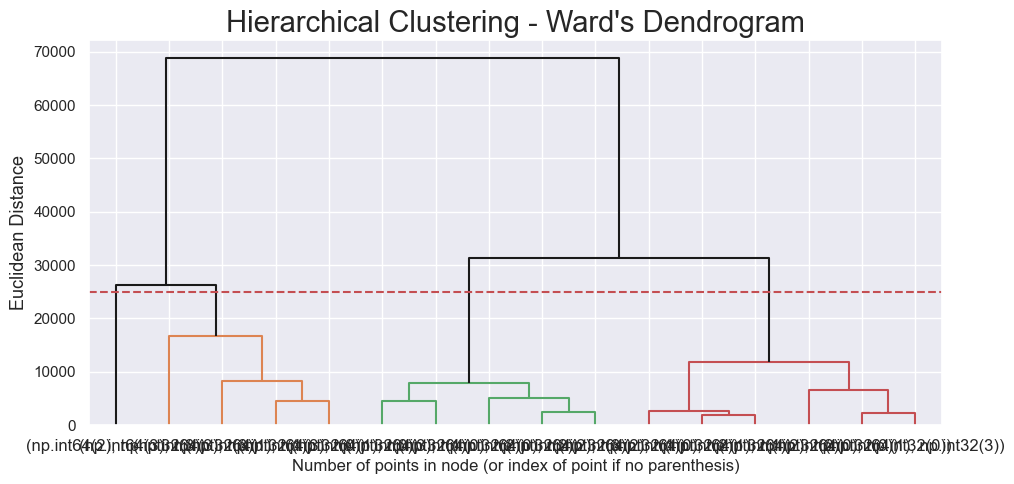

In [128]:
# Using Hierarchical clustering to merge the concatenated cluster centroids
linkage = 'ward'
hclust = AgglomerativeClustering(
    linkage=linkage, 
    metric='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)

hclust_labels = hclust.fit_predict(df1_centroids)

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned

y_threshold = 25000
# y_threshold = 3.3

dendrogram(linkage_matrix, 
           truncate_mode='level', 
           labels=df1_centroids.index, p=5, 
           color_threshold=y_threshold, 
           above_threshold_color='k')

plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)

In [130]:
# Re-running the Hierarchical clustering based on the correct number of clusters
hclust = AgglomerativeClustering(
    linkage='ward', 
    metric='euclidean', 
    n_clusters= 4
)
hclust_labels = hclust.fit_predict(df1_centroids)
df1_centroids['hclust_labels'] = hclust_labels

df1_centroids  # centroid's cluster labels

Customer Lifetime Value  UnredeemedPoints  \
hierarchical_cluster cluster1                                              
0                    0                     7813.240833      33099.583333   
                     1                     6323.253750      38658.562500   
                     2                     6202.343846      54802.076923   
                     3                     5069.325000      49549.100000   
1                    0                     6774.594545      19306.818182   
                     1                    10260.161333      48979.533333   
                     2                     7544.958333      40213.250000   
                     3                     9725.388000      32275.800000   
2                    0                    12075.430000      37271.800000   
                     1                     4501.300000      51761.000000   
                     2                     5630.370000      41344.000000   
                     3                     4609.865000        555.500000   
3                    0                     2487.730000      20304.000000   
                     1                     2644.680000      26581.000000   
                     2                     6184.055000      46964.000000   
                     3                    17056.396667      18107.333333   

                               PointsRedeemedRatio  KMPerRedeemedPoint  \
hierarchical_cluster cluster1                                            
0                    0                    0.285128           36.429031   
                     1                    0.242571           41.514801   
                     2                    0.241126           78.435380   
                     3                    0.173507           67.698423   
1                    0                    0.445386           25.684674   
                     1                    0.252359           37.621266   
                     2                    0.317421           34.122392   
                     3                    0.412906           17.607851   
2                    0                    0.213612           44.937302   
                     1                    0.247623           59.179626   
                     2                    0.220371           21.146497   
                     3                    0.369325            6.771815   
3                    0                    0.176208           56.762837   
                     1                    0.373843           26.755394   
                     2                    0.345555           36.098430   
                     3                    0.411179           12.727090   

                               Time on Program  EnrollmentMonth  hclust_labels  
hierarchical_cluster cluster1                                                   
0                    0              791.916667         3.583333              1  
                     1             2068.625000         3.187500              1  
                     2             2244.692308         8.923077              2  
                     3             1258.100000        10.600000              2  
1                    0              929.363636         3.818182              0  
                     1             2219.600000         3.800000              2  
                     2             2205.416667         8.916667              1  
                     3             1456.800000        10.200000              1  
2                    0              803.200000         3.000000              1  
                     1             1935.428571         3.714286              2  
                     2             2187.333333         8.333333              1  
                     3             1162.500000        10.000000              3  
3                    0             1391.000000         3.000000              0  
                     1             2181.000000         1.000000              0  
                     2           

In [132]:
df_1 = FlightsDB_1.copy()
# Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = df1_centroids['hclust_labels'].to_dict()
cluster_mapper
# Mapping the hierarchical clusters on the centroids to the observations
df_1['Merged_Cluster_1'] = df_1.apply(
    lambda row: cluster_mapper[
        (row['hierarchical_cluster'], row['cluster1'])
    ], axis=1
)

df_1

,Loyalty#,PointsRedeemedRatio,FlightsWithCompanionsRatio,AvgDistancePerFlight,KMPerRedeemedPoint,UnredeemedPoints,HasBonus,AvgMonthlyFlights,sr_jan,sr_feb,...,CancellationDate,Customer Lifetime Value,EnrollmentType,Cancelled,Time on Program,EnrollmentMonth,Reenroll,cluster1,hierarchical_cluster,Merged_Cluster_1
0,101902,0.182369,0.176966,2131.451124,54.850123,62023,0,5.741935,0.016854,0.022472,...,0,6265.34,Standard,N,723,1,0,0,0,1
1,106001,0.395167,0.241814,2039.651889,25.313924,48960,0,5.591549,0.093199,0.110831,...,0,12168.74,Standard,N,2359,7,0,2,3,2
2,114414,0.034855,0.205776,2782.755957,286.978183,74377,0,3.957143,0.090253,0.126354,...,0,3591.07,Standard,N,2246,11,0,2,0,2
3,130331,0.202501,0.426230,2851.959016,49.395088,27741,0,2.595745,0.000000,0.032787,...,0,2862.73,Standard,N,760,12,0,3,0,2
4,135421,0.141525,0.328947,2590.785197,70.674686,67598,0,4.676923,0.055921,0.069079,...,0,5304.54,Standard,N,1475,12,0,3,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,969318,0.142824,0.237569,2367.100829,70.036003,73430,0,5.098592,0.022099,0.066298,...,0,4347.59,Standard,N,1988,7,0,2,0,2
116,971370,0.192329,0.398176,2072.238906,52.011489,55046,0,4.700000,0.063830,0.066869,...,0,5261.04,Standard,N,2358,7,0,2,1,1
117,972686,0.087747,0.182109,2329.895847,113.999906,66506,0,4.671642,0.025559,0.086262,...,0,5123.17,Standard,N,2138,2,0,1,2,2
118,974875,0.432803,0.326705,2296.601136,23.112434,45838,0,4.888889,0.042614,0.088068,...,0,4118.59,Standard,N,2059,5,0,1,2,2


In [133]:
numerical_columns = df_1.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_columns = [col for col in numerical_columns if col != 'hierarchical_cluster' and col != 'cluster1' and col != 'Merged_Cluster_1']
df_1.groupby('Merged_Cluster_1').mean(numeric_only=True)[numerical_columns]

,Loyalty#,PointsRedeemedRatio,FlightsWithCompanionsRatio,AvgDistancePerFlight,KMPerRedeemedPoint,UnredeemedPoints,HasBonus,AvgMonthlyFlights,sr_jan,sr_feb,...,sr_aug,sr_sep,sr_oct,sr_nov,sr_dec,Income,CancellationDate,Customer Lifetime Value,Time on Program,Reenroll
Merged_Cluster_1,,,,,,,,,,,,,,,,,,,,,
0,579897.375000,0.417677,0.226709,1955.585070,25.264432,19598.875000,0.0,2.477928,0.023670,0.033193,...,0.095205,0.066107,0.101136,0.156290,0.260886,41081.250000,0.0,8176.383750,1107.562500,0.0
1,621882.226415,0.281235,0.286023,2219.482562,35.604135,37170.962264,0.0,3.882088,0.049134,0.036585,...,0.097770,0.100945,0.101435,0.100051,0.161864,41518.226415,0.0,7761.616038,1640.150943,0.0
2,550765.040816,0.240218,0.235607,2031.883798,57.543148,50873.346939,0.0,4.816781,0.046586,0.051572,...,0.094556,0.089114,0.070277,0.071022,0.090642,34115.469388,0.0,6968.805306,1986.795918,0.0
3,770759.000000,0.369325,0.159091,966.522727,6.771815,555.500000,0.0,0.282051,0.000000,0.000000,...,0.000000,0.000000,0.181818,0.227273,0.090909,11562.000000,0.0,4609.865000,1162.500000,0.0


In [134]:
# Merge cluster contigency table
# Getting size of each final cluster
df_counts = df_1.groupby('Merged_Cluster_1')\
    .size()\
    .to_frame()

df_counts

,0
Merged_Cluster_1,
0,16
1,53
2,49
3,2


Text(0, 0.5, 'Euclidean Distance')

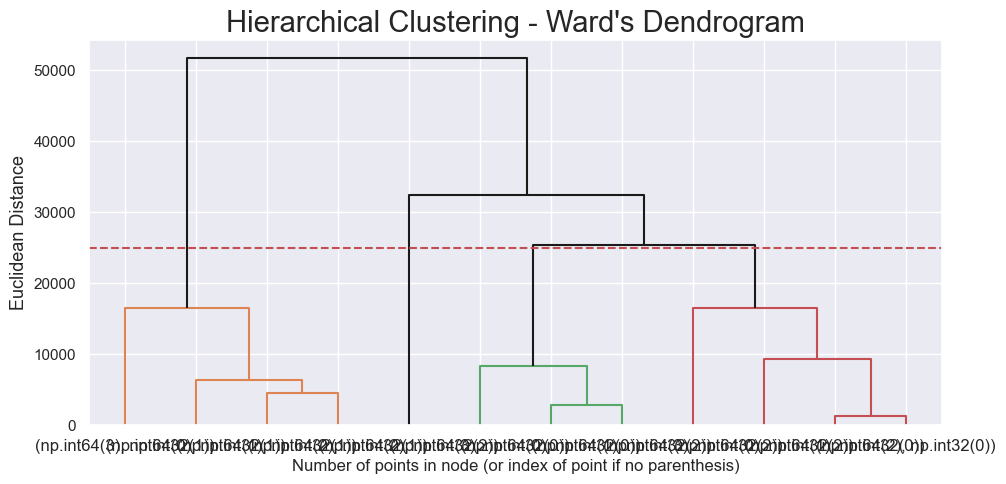

In [129]:
# Using Hierarchical clustering to merge the concatenated cluster centroids
linkage = 'ward'
hclust = AgglomerativeClustering(
    linkage=linkage, 
    metric='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)

hclust_labels = hclust.fit_predict(df2_centroids)

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned

y_threshold = 25000
# y_threshold = 3.3

dendrogram(linkage_matrix, 
           truncate_mode='level', 
           labels=df2_centroids.index, p=5, 
           color_threshold=y_threshold, 
           above_threshold_color='k')

plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)

In [135]:
# Re-running the Hierarchical clustering based on the correct number of clusters
hclust = AgglomerativeClustering(
    linkage='ward', 
    metric='euclidean', 
    n_clusters= 4
)
hclust_labels = hclust.fit_predict(df2_centroids)
df2_centroids['hclust_labels'] = hclust_labels

df2_centroids  # centroid's cluster labels

Customer Lifetime Value  UnredeemedPoints  \
hierarchical_cluster cluster2                                              
0                    0                     6878.630000      42321.181818   
                     1                     7880.537273      28889.454545   
                     2                     5175.192000      55609.533333   
1                    0                    10255.888000      49122.950000   
                     1                     7178.407692      23725.923077   
                     2                     4360.045000      43444.000000   
2                    0                     8974.402500      48717.375000   
                     1                    11674.440000      23591.285714   
                     2                    33053.270000      45838.000000   
3                    0                     6160.578571      35657.285714   
                     1                    22337.175000      24587.500000   
                     2                    18556.350000      59655.500000   

                               PointsRedeemedRatio  KMPerRedeemedPoint  \
hierarchical_cluster cluster2                                            
0                    0                    0.239741           46.950667   
                     1                    0.243149           26.785980   
                     2                    0.215915           61.060695   
1                    0                    0.254832           47.782933   
                     1                    0.379646           34.937245   
                     2                    0.464652           21.663867   
2                    0                    0.336212           68.511832   
                     1                    0.427076           20.285671   
                     2                    0.432803           23.112434   
3                    0                    0.351523           50.114187   
                     1                    0.217437           11.501640   
                     2                    0.220635           51.648978   

                               Time on Program  EnrollmentMonth  hclust_labels  
hierarchical_cluster cluster2                                                   
0                    0              834.272727         3.363636              3  
                     1              354.000000         9.227273              1  
                     2             1630.666667         9.933333              0  
1                    0              768.550000         3.200000              0  
                     1              369.615385         9.615385              1  
                     2             1370.500000         8.500000              3  
2                    0              788.875000         3.625000              0  
                     1              401.285714         8.571429              1  
                     2             1484.000000        11.000000              2  
3                    0              889.428571         2.857143              3  
                     1              509.000000         7.000000              1  
                     2             1897.000000         9.000000              0

In [136]:

df_2 = FlightsDB_2.copy()
# Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = df2_centroids['hclust_labels'].to_dict()
cluster_mapper
# Mapping the hierarchical clusters on the centroids to the observations
df_2['Merged_Cluster_1'] = df_2.apply(
    lambda row: cluster_mapper[
        (row['hierarchical_cluster'], row['cluster2'])
    ], axis=1
)

df_2

,Loyalty#,PointsRedeemedRatio,FlightsWithCompanionsRatio,AvgDistancePerFlight,KMPerRedeemedPoint,UnredeemedPoints,HasBonus,AvgMonthlyFlights,sr_jan,sr_feb,...,CancellationDate,Customer Lifetime Value,EnrollmentType,Cancelled,Time on Program,EnrollmentMonth,Reenroll,cluster2,hierarchical_cluster,Merged_Cluster_1
0,101902,0.182369,0.176966,2131.451124,54.850123,62023,0,5.741935,0.016854,0.022472,...,0,8609.16,Standard,N,624,3,0,0,1,0
1,106001,0.395167,0.241814,2039.651889,25.313924,48960,0,5.591549,0.093199,0.110831,...,0,4914.04,Standard,N,2153,1,0,0,0,3
2,114414,0.034855,0.205776,2782.755957,286.978183,74377,0,3.957143,0.090253,0.126354,...,0,2617.70,Standard,N,2177,12,0,2,0,0
3,130331,0.202501,0.426230,2851.959016,49.395088,27741,0,2.595745,0.000000,0.032787,...,0,11638.90,Standard,N,309,1,0,0,3,3
4,135421,0.141525,0.328947,2590.785197,70.674686,67598,0,4.676923,0.055921,0.069079,...,0,17441.64,Standard,N,696,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,971370,0.192329,0.398176,2072.238906,52.011489,55046,0,4.700000,0.063830,0.066869,...,0,4542.41,Standard,N,1607,7,0,2,0,0
117,972686,0.087747,0.182109,2329.895847,113.999906,66506,0,4.671642,0.025559,0.086262,...,0,3873.65,Standard,N,1868,10,0,2,0,0
118,974875,0.432803,0.326705,2296.601136,23.112434,45838,0,4.888889,0.042614,0.088068,...,0,33053.27,Standard,N,1484,11,0,2,2,2
119,979115,0.294850,0.423729,3533.795763,33.923519,29397,0,2.313725,0.025424,0.067797,...,0,9180.15,Standard,N,466,8,0,1,2,1


In [137]:

numerical_columns = df_2.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_columns = [col for col in numerical_columns if col != 'hierarchical_cluster' and col != 'cluster2' and col != 'Merged_Cluster_1']
df_2.groupby('Merged_Cluster_1').mean(numeric_only=True)[numerical_columns]
# Merge cluster contigency table

,Loyalty#,PointsRedeemedRatio,FlightsWithCompanionsRatio,AvgDistancePerFlight,KMPerRedeemedPoint,UnredeemedPoints,HasBonus,AvgMonthlyFlights,sr_jan,sr_feb,...,sr_jul,sr_aug,sr_sep,sr_oct,sr_nov,sr_dec,Income,Customer Lifetime Value,Time on Program,Reenroll
Merged_Cluster_1,,,,,,,,,,,,,,,,,,,,,
0,598430.666667,0.254807,0.267063,2169.790268,56.065816,51681.155556,0.0,4.912691,0.065860,0.048260,...,0.119321,0.109094,0.090647,0.084802,0.066901,0.099240,41470.333333,8703.412444,1109.688889,0.022222
1,614953.409091,0.311570,0.246506,2049.349062,27.465425,26325.431818,0.0,2.937012,0.031503,0.036393,...,0.060419,0.082531,0.088524,0.101471,0.146704,0.223856,35281.545455,8933.785227,373.181818,0.022727
2,974875.000000,0.432803,0.326705,2296.601136,23.112434,45838.000000,0.0,4.888889,0.042614,0.088068,...,0.099432,0.142045,0.116477,0.051136,0.022727,0.045455,44246.000000,33053.270000,1484.000000,0.000000
3,541497.548387,0.279493,0.252122,2014.637919,46.033604,40888.870968,0.0,4.170461,0.028165,0.036647,...,0.111903,0.089123,0.092909,0.080236,0.072860,0.102741,44783.161290,6554.000000,881.322581,0.032258


In [138]:
df_counts2 = df_2.groupby('Merged_Cluster_1')\
    .size()\
    .to_frame()

df_counts2

,0
Merged_Cluster_1,
0,45
1,44
2,1
3,31
